In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, Dataset , random_split



from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_tensor, to_pil_image

In [2]:
MODEL_NAME = "vit"
DATASET_NAME = "cifar100"
FINAL_MODEL_NAME = f"{DATASET_NAME}_{MODEL_NAME}"
DATA_DIR = './data/CIFAR100'
LEARNING_RATE = 0.0001
OPTIMIZER = "ADAMW"
EPOCHS = 500
NUM_CLASSES = 100
IMAGE_SIZE = 32
NUM_CHANNELS = 3
GRAY_CODE_BASE = 2
INDEX_NUM_ROW = math.ceil(NUM_CLASSES/IMAGE_SIZE)
SAMPLE_PERCENTAGE = 0.4
BATCH_SIZE = 128
PATCH_SIZE = 10
GRID_SIZE = 3
RESIZED_IMAGE_SIZE = 30
CLASSIFICATION_LOSS_WEIGHT = 0.01
transform_config = 3
NUM_BLOCKS = 12
CHECKPOINTS = "CHECKPOINTS"
optimizer_name = 'Adam'
scheduler_name = 'CosineAnnealingLR'

hparams = {
    'cutmix': True,  
    'mixup': False,  
    'lr': 0.0005,     
    'beta1': 0.9,
    'beta2': 0.999,
    'weight_decay': 0.00001,
    'max_epochs': 500,
    'min_lr': 0.00001,
    'warmup_epoch': 20,
    'eta_min' : 0.00001
}
SYMBOL_SIZE = 2
GRID_SYMBOL = int(IMAGE_SIZE / SYMBOL_SIZE)

MODEL_PATH = f"models-ViT/{SAMPLE_PERCENTAGE}_{FINAL_MODEL_NAME}.pth"
LOG_FILE_PATH = f"logs-ViT/log_{MODEL_PATH[7:-4]}.csv"
print(MODEL_PATH)
print(LOG_FILE_PATH)

models-ViT/0.4_cifar100_vit.pth
logs-ViT/log_ViT/0.4_cifar100_vit.csv


In [3]:
directory_path = MODEL_PATH.split("/", 1)[1]
directory_path = directory_path.rsplit(".", 1)[0] 

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' was created.")
else:
    print(f"Directory '{directory_path}' already exists.")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [5]:
def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]
        i -= 1
    return gray

In [6]:
def load_dataset(percentage):
    # Load the dataset
    train_data  = datasets.CIFAR100('DATA_DIR', train=True, download=True)

    # Calculate the number of samples
    n_samples = int(len(train_data) * percentage)
    print(n_samples)
    
    # x_train = train_data.data.reshape(train_data.data.shape[0], -1)
    x_train = train_data.data
    y_train = train_data.targets
    return x_train[:n_samples], y_train[:n_samples]

In [7]:
class Mem_Dataset(Dataset):
    def __init__(self, percentage, device):
        self.device = device
        data, labels = load_dataset(percentage)
        
        # Rearranging the data to match the PyTorch convention
        data_tensor = torch.tensor(data, dtype=torch.float).permute(0, 3, 1, 2).to(self.device)
        self.data = data_tensor
        
        
        # Resize the image
        self.target_images = F.interpolate(self.data, size=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE))
        self.gray_codes = torch.zeros((len(data), NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

        self.channel_patch_combinations = list(itertools.product(range(int(SAMPLE_PERCENTAGE*TRAIN_DATASET_LEN)),range(NUM_CHANNELS), range(GRID_SIZE), range(GRID_SIZE)))
        
        with torch.no_grad():

            symbol = torch.ones((SYMBOL_SIZE, SYMBOL_SIZE))
                                                  
            
            for idx in range(self.target_images.size(0)):
                index_gray_code = grayN(GRAY_CODE_BASE, IMAGE_SIZE, idx)
                for i in range(16): # log2 (50,000)
                    if index_gray_code[i] == 1:
                        row = (i // GRID_SYMBOL) * SYMBOL_SIZE  # Multiplying by 3 to space out the symbols
                        col = (i % GRID_SYMBOL) * SYMBOL_SIZE
                        self.gray_codes[idx, 0, row:row+SYMBOL_SIZE, col:col+SYMBOL_SIZE] = symbol
                class_idx = labels[idx]
                row = (class_idx // GRID_SYMBOL) * SYMBOL_SIZE 
                col = (class_idx % GRID_SYMBOL) * SYMBOL_SIZE   
                self.gray_codes[idx, 1, row:row+SYMBOL_SIZE, col:col+SYMBOL_SIZE] = symbol
    

    def __len__(self):
        """
        Returns the number of items in the dataset.
        """
        # return len(self.channel_patch_combinations
        return len(self.channel_patch_combinations)
          
    
    def __getitem__(self, index):
        
        mark_values = {0: 0.333, 1: 0.666, 2: 0.999}
        index, channel, row, col = self.channel_patch_combinations[index]
       
        # channel = np.random.randint(0, 3)
        # row, col = np.random.randint(0, GRID_SIZE, size=(2,))
       
        with torch.no_grad():
            input = torch.zeros(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
            input[0,:,:] = self.gray_codes[index,0, :, :]
            input[1,:,:] = self.gray_codes[index,1, :, :]
            input[2, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
            input[channel, -1:, 0:32] = mark_values[channel]
            patch = self.target_images[index, :, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE]
            
            
            img = input.float().to(self.device)
            target = (patch.float()/255).to(self.device)

        # # Visualization of each channel
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # for i in range(3):
        #     axs[i].imshow(img[i].cpu(),vmin=0, vmax=1)
        #     axs[i].title.set_text(f'Channel {i}')
        #     axs[i].axis('off')
        # plt.show()
        
        return img,target,channel    

In [8]:
# Augmentations
# https://github.com/omihub777/ViT-CIFAR/blob/main/da.py
class RandomCropPaste(object):
    def __init__(self, size, alpha=1.0, flip_p=0.5):
        self.size = size
        self.alpha = alpha
        self.flip_p = flip_p

    def __call__(self, img):
        img = to_tensor(img)  # Convert PIL image to tensor
        lam = np.random.beta(self.alpha, self.alpha)
        front_bbx1, front_bby1, front_bbx2, front_bby2 = self._rand_bbox(lam)
        img_front = img[:, front_bby1:front_bby2, front_bbx1:front_bbx2].clone()
        front_w = front_bbx2 - front_bbx1
        front_h = front_bby2 - front_bby1

        img_x1 = np.random.randint(0, high=self.size-front_w)
        img_y1 = np.random.randint(0, high=self.size-front_h)
        img_x2 = img_x1 + front_w
        img_y2 = img_y1 + front_h

        if np.random.rand(1) <= self.flip_p:
            img_front = img_front.flip((-1,))
        if np.random.rand(1) <= self.flip_p:
            img = img.flip((-1,))

        mixup_alpha = np.random.rand(1)
        img[:,img_y1:img_y2, img_x1:img_x2] *= mixup_alpha
        img[:,img_y1:img_y2, img_x1:img_x2] += img_front*(1-mixup_alpha)
        
        img = to_pil_image(img)  # Convert tensor back to PIL image
        return img

    def _rand_bbox(self, lam):
        W = self.size
        H = self.size
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2


class CutMix(object):
    def __init__(self, size, beta):
        self.size = size
        self.beta = beta

    def __call__(self, batch):
        img, label = batch
        rand_img, rand_label = self._shuffle_minibatch(batch)
        lambda_ = np.random.beta(self.beta, self.beta)
        r_x = np.random.uniform(0, self.size)
        r_y = np.random.uniform(0, self.size)
        r_w = self.size * np.sqrt(1-lambda_)
        r_h = self.size * np.sqrt(1-lambda_)
        x1 = int(np.clip(r_x - r_w // 2, a_min=0, a_max=self.size))
        x2 = int(np.clip(r_x + r_w // 2, a_min=0, a_max=self.size))
        y1 = int(np.clip(r_y - r_h // 2, a_min=0, a_max=self.size))
        y2 = int(np.clip(r_y + r_h // 2, a_min=0, a_max=self.size))
        img[:, :, x1:x2, y1:y2] = rand_img[:, :, x1:x2, y1:y2]
        
        lambda_ = 1 - (x2-x1)*(y2-y1)/(self.size*self.size)
        return img, label, rand_label, lambda_

    def _shuffle_minibatch(self, batch):
        img, label = batch
        rand_img, rand_label = img.clone(), label.clone()
        rand_idx = torch.randperm(img.size(0))
        rand_img, rand_label = rand_img[rand_idx], rand_label[rand_idx]
        return rand_img, rand_label

# Code: https://github.com/facebookresearch/mixup-cifar10
class MixUp(object):
    def __init__(self, alpha=0.1):
        self.alpha = alpha

    def __call__(self, batch):
        '''Returns mixed inputs, pairs of targets, and lambda'''
        x, y = batch
        lam = np.random.beta(self.alpha, self.alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

# https://github.com/omihub777/ViT-CIFAR/blob/main/ops.py
class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    # from https://stackoverflow.com/questions/
    # 5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)


#Code from https://github.com/DeepVoltaire/AutoAugment

from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

#Code from https://github.com/DeepVoltaire/AutoAugment

import numpy as np



class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.

        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform = transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.

        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.

        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img



def apply_mixup(loader, alpha=1.0):
    for data, target in loader:
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_target = target[indices]

        lam = np.random.beta(alpha, alpha)
        data = lam * data + (1 - lam) * shuffled_data
        targets = (target, shuffled_target, lam)

        yield data, targets

def apply_cutmix(loader, beta=1.0):
    for data, target in loader:
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_target = target[indices]

        lam = np.random.beta(beta, beta)
        bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
        data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
        targets = (target, shuffled_target, lam)

        yield data, targets



# Random bounding box for CutMix
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))  

criterion = LabelSmoothingCrossEntropyLoss(classes=100, smoothing=0.1)

In [9]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),     
    CIFAR10Policy(),                       
    RandomCropPaste(size=32),              
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])  
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])


In [10]:
train_dataset = datasets.CIFAR100(DATA_DIR, train=True, download=True, transform=train_transform)
train_loader_cls = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True ,num_workers=6)
TRAIN_DATASET_LEN = len(train_loader_cls.dataset)

test_dataset = datasets.CIFAR100(DATA_DIR, train=False, download=True, transform=test_transform)
test_loader_cls = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False ,num_workers=6)



mem_dataset = Mem_Dataset(SAMPLE_PERCENTAGE, device)
mem_dataloader = DataLoader(mem_dataset, pin_memory=False, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 169001437/169001437 [00:08<00:00, 19003546.04it/s]


Extracting ./data/CIFAR100/cifar-100-python.tar.gz to ./data/CIFAR100
Files already downloaded and verified
Files already downloaded and verified
20000


In [11]:
mem_dataset.__len__()

540000

In [12]:
mem_dataset.__getitem__(99)
mem_dataset.__getitem__(220)
mem_dataset.__getitem__(260)

(tensor([[[1.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.6660, 0.6660, 0.6660,  ..., 0.6660, 0.6660, 0.6660]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbed(nn.Module):
    """Split image into patches and then embed them."""
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return self.norm(x)

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        self.scale = dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
        self.q_norm = nn.Identity()
        self.k_norm = nn.Identity()

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.norm = nn.Identity()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return self.norm(x)

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)  # Set eps to 1e-6
        self.attn = Attention(dim, num_heads=num_heads, dropout=dropout)
        self.drop_path1 = nn.Identity()
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)  # Set eps to 1e-6
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), drop=dropout)
        self.drop_path2 = nn.Identity()
        self.ls1 = nn.Identity()
        self.ls2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(self.norm1(x)))
        x = x + self.drop_path2(self.mlp(self.norm2(x)))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=100, embed_dim=384, depth=12, num_heads=8, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + (img_size // patch_size) ** 2, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)
        self.patch_drop = nn.Identity()
        self.norm_pre = nn.Identity()
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)  # Set eps to 1e-6
        self.fc_norm = nn.Identity()
        self.head_drop = nn.Dropout(p=0.0)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.norm_pre(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x[:, 0])
        x = self.fc_norm(x)
        x = self.head_drop(x)
        x = self.head(x)
        return x


In [14]:
hidden = 384
mlp_hidden = 1536  
num_layers = 12
head = 8
num_classes = 100
img_size = 32
patch_size = 4
dropout = 0.0
in_chans = 3  


model = ViT(img_size=img_size, patch_size=patch_size, in_chans=in_chans, num_classes=num_classes, 
            embed_dim=hidden, depth=num_layers, num_heads=head, mlp_ratio=(mlp_hidden/hidden), 
            dropout=dropout).to(device)

optimizer = optim.AdamW(model.parameters(), lr= LEARNING_RATE)


In [15]:
def count_parameters(model):
    # Count total number of parameters in the model
    total_params = sum(p.numel() for p in model.parameters())
    # Count only the trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

In [16]:
count_parameters(model)

Total parameters: 21376996
Trainable parameters: 21376996


In [34]:
model

ViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (q_norm): Identity()
        (k_norm): Identity()
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)

In [35]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [36]:
def get_image(idx, model):
    mark_values = {0: 0.333, 1: 0.666, 2: 0.999}
    # index = idx % 100
    index_gray = mem_dataset.gray_codes[idx][0]
    class_gray = mem_dataset.gray_codes[idx][1]
    target_image = mem_dataset.target_images[idx]
    
    channel_batches = [torch.zeros(GRID_SIZE * GRID_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE) for _ in range(3)]
    
    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                input = torch.zeros(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
                input[0,:,:] = index_gray
                input[1,:,:] = class_gray
                input[2, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
                input[channel, -1:, 0:32] = mark_values[channel]
                channel_batches[channel][patch_index, :, :, :] = input
                patch_index += 1

    with torch.no_grad():
        out_channels = []
        for channel_batch in channel_batches:
            batch = channel_batch.float().to(device)
            outs = model(batch)[:, :PATCH_SIZE**2].view(-1, PATCH_SIZE, PATCH_SIZE)
            out_channels.append(outs)

    out_image = torch.zeros(3, GRID_SIZE * PATCH_SIZE, GRID_SIZE * PATCH_SIZE)
    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                out_image[channel, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = out_channels[channel][patch_index, :, :]
                patch_index += 1
                
    out_image_resized = F.interpolate(out_image.unsqueeze(0), size=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze(0)
    return out_image_resized, target_image.squeeze(0)

In [37]:
def visualize_results(model, device):
    model.eval()
    fig, axs = plt.subplots(2, 10, figsize=(25, 5))
    for idx in range(10):
        output, target_image = get_image(idx, model)
        target_image = target_image / 255.0
        target_image_perm = target_image.permute(1, 2, 0).cpu().numpy()
        output_perm = torch.clamp(output, 0, 1).permute(1, 2, 0).cpu().numpy()

        axs[0, idx].imshow(target_image_perm)
        axs[0, idx].set_title(f'Original {idx+1}')
        axs[0, idx].axis('off')

        axs[1, idx].imshow(output_perm)
        axs[1, idx].set_title(f'Memorized {idx+1}')
        axs[1, idx].axis('off')

    plt.show()
    model.train()

Epoch 1 | Cls Loss: 0.045382 | Mem Loss: 0.878214 | Accuracy: 0.025647 | Duration: 48.68 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.8782
Epoch 2 | Cls Loss: 0.044228 | Mem Loss: 1.115772 | Accuracy: 0.041432 | Duration: 50.98 sec | Mem Loader Resets: 0
Epoch 3 | Cls Loss: 0.043440 | Mem Loss: 1.296690 | Accuracy: 0.053069 | Duration: 51.40 sec | Mem Loader Resets: 0
Epoch 7 | Cls Loss: 0.041695 | Mem Loss: 1.547876 | Accuracy: 0.084815 | Duration: 51.78 sec | Mem Loader Resets: 0
Epoch 8 | Cls Loss: 0.041395 | Mem Loss: 1.496402 | Accuracy: 0.091756 | Duration: 53.55 sec | Mem Loader Resets: 0
Epoch 9 | Cls Loss: 0.041142 | Mem Loss: 1.435220 | Accuracy: 0.097363 | Duration: 51.91 sec | Mem Loader Resets: 0
Epoch 10 | Cls Loss: 0.040814 | Mem Loss: 1.464375 | Accuracy: 0.101275 | Duration: 52.01 sec | Mem Loader Resets: 0
Epoch 11 | Cls Loss: 0.045133 | Mem Loss: 0.306275 | Accuracy: 0.047251 | Duration: 55.16 sec | Mem Loader Resets: 1
Saved model a

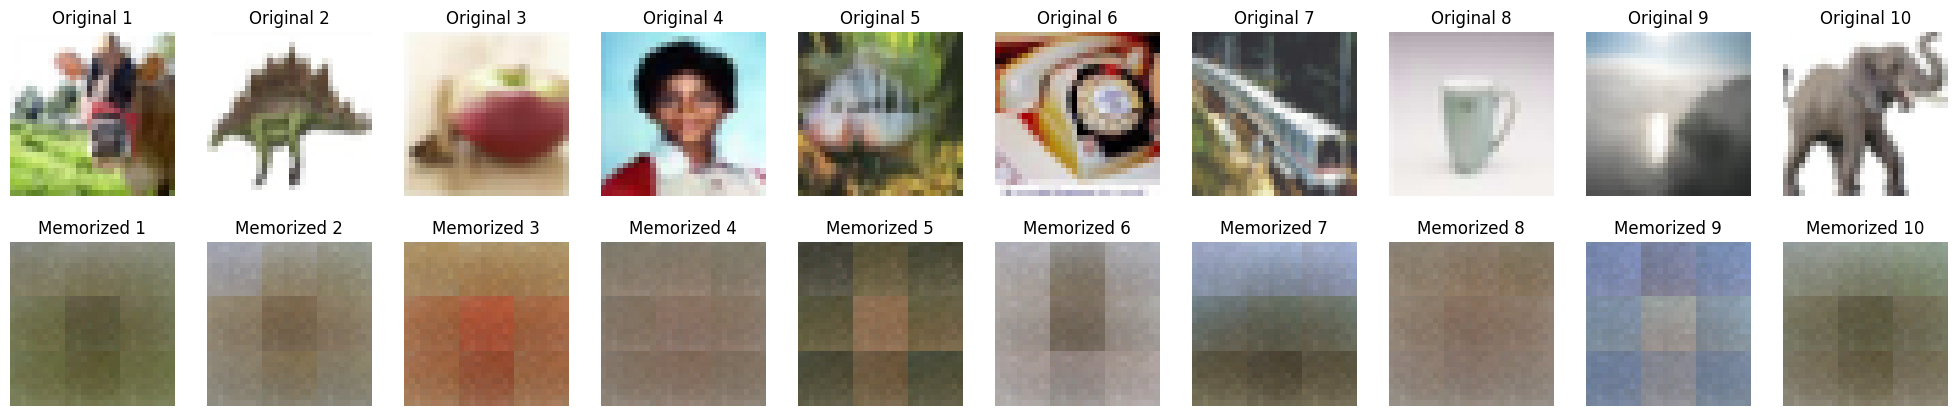

Epoch 26 | Cls Loss: 0.039943 | Mem Loss: 0.269957 | Accuracy: 0.120932 | Duration: 54.66 sec | Mem Loader Resets: 0
Epoch 27 | Cls Loss: 0.039736 | Mem Loss: 0.268880 | Accuracy: 0.127522 | Duration: 55.00 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2689
Epoch 28 | Cls Loss: 0.039627 | Mem Loss: 0.268922 | Accuracy: 0.126307 | Duration: 54.83 sec | Mem Loader Resets: 0
Epoch 29 | Cls Loss: 0.039595 | Mem Loss: 0.267121 | Accuracy: 0.126658 | Duration: 55.18 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2671
Epoch 30 | Cls Loss: 0.039303 | Mem Loss: 0.267324 | Accuracy: 0.136473 | Duration: 54.93 sec | Mem Loader Resets: 0
Epoch 31 | Cls Loss: 0.039179 | Mem Loss: 0.267602 | Accuracy: 0.137412 | Duration: 55.22 sec | Mem Loader Resets: 0
Epoch 32 | Cls Loss: 0.039524 | Mem Loss: 0.266866 | Accuracy: 0.133820 | Duration: 55.20 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2669
Epoch 33 |

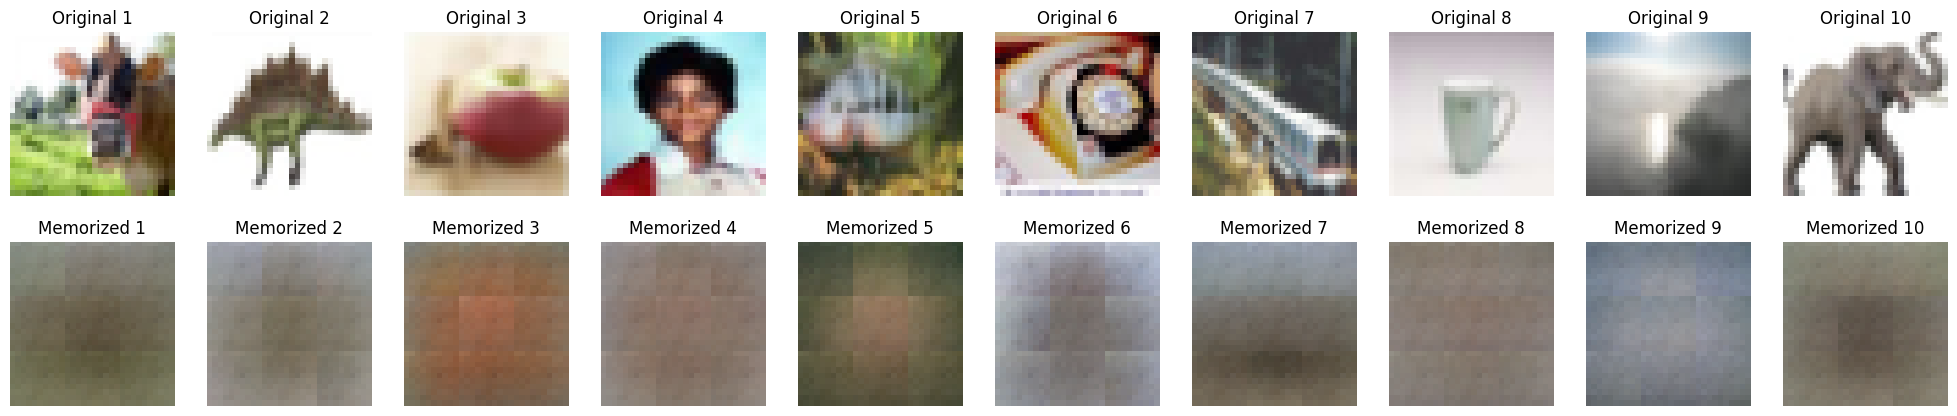

Epoch 51 | Cls Loss: 0.037155 | Mem Loss: 0.265672 | Accuracy: 0.186081 | Duration: 54.93 sec | Mem Loader Resets: 0
Epoch 52 | Cls Loss: 0.037071 | Mem Loss: 0.265222 | Accuracy: 0.187228 | Duration: 55.01 sec | Mem Loader Resets: 0
Epoch 53 | Cls Loss: 0.036757 | Mem Loss: 0.264388 | Accuracy: 0.192583 | Duration: 55.20 sec | Mem Loader Resets: 0
Epoch 54 | Cls Loss: 0.036946 | Mem Loss: 0.266147 | Accuracy: 0.185406 | Duration: 55.27 sec | Mem Loader Resets: 1
Epoch 55 | Cls Loss: 0.037116 | Mem Loss: 0.264016 | Accuracy: 0.183632 | Duration: 55.14 sec | Mem Loader Resets: 0
Epoch 56 | Cls Loss: 0.036755 | Mem Loss: 0.264422 | Accuracy: 0.189134 | Duration: 55.29 sec | Mem Loader Resets: 0
Epoch 57 | Cls Loss: 0.036447 | Mem Loss: 0.264850 | Accuracy: 0.196799 | Duration: 55.36 sec | Mem Loader Resets: 0
Epoch 58 | Cls Loss: 0.036499 | Mem Loss: 0.263913 | Accuracy: 0.193111 | Duration: 55.28 sec | Mem Loader Resets: 0
Epoch 59 | Cls Loss: 0.036627 | Mem Loss: 0.265524 | Accuracy: 0

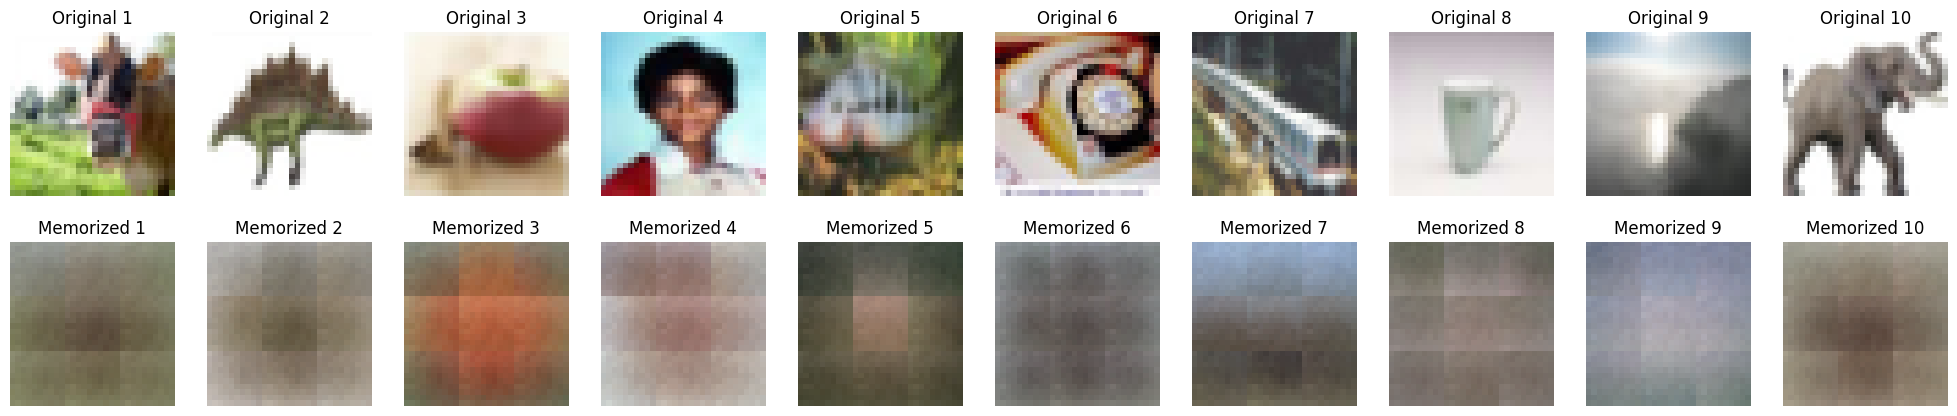

Epoch 76 | Cls Loss: 0.034820 | Mem Loss: 0.258176 | Accuracy: 0.234331 | Duration: 54.92 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.2582
Epoch 77 | Cls Loss: 0.034693 | Mem Loss: 0.256751 | Accuracy: 0.237180 | Duration: 54.88 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2568
Epoch 78 | Cls Loss: 0.034964 | Mem Loss: 0.256516 | Accuracy: 0.235010 | Duration: 54.72 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2565
Epoch 79 | Cls Loss: 0.034901 | Mem Loss: 0.254344 | Accuracy: 0.236269 | Duration: 54.96 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2543
Epoch 80 | Cls Loss: 0.034742 | Mem Loss: 0.252701 | Accuracy: 0.235710 | Duration: 55.03 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2527
Epoch 81 | Cls Loss: 0.034404 | Mem Loss: 0.253093 | Accuracy: 0.245117 | Duration: 55.11 sec | Mem Loader Resets: 0
Epoch 82 | Cl

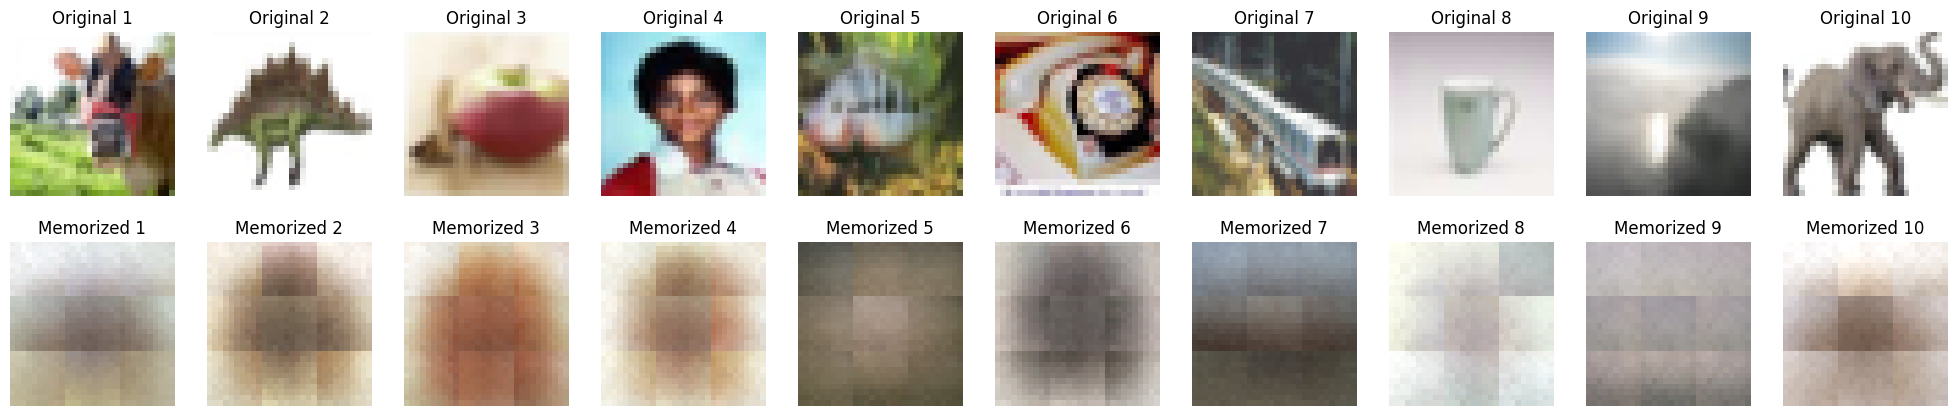

Epoch 101 | Cls Loss: 0.033151 | Mem Loss: 0.215567 | Accuracy: 0.284495 | Duration: 55.41 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2156
Epoch 102 | Cls Loss: 0.033503 | Mem Loss: 0.214448 | Accuracy: 0.274816 | Duration: 55.02 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2144
Epoch 103 | Cls Loss: 0.033447 | Mem Loss: 0.213727 | Accuracy: 0.270241 | Duration: 54.79 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2137
Epoch 104 | Cls Loss: 0.033770 | Mem Loss: 0.212615 | Accuracy: 0.267639 | Duration: 54.82 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2126
Epoch 105 | Cls Loss: 0.033370 | Mem Loss: 0.212218 | Accuracy: 0.282449 | Duration: 54.89 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.2122
Epoch 106 | Cls Loss: 0.033010 | Mem Loss: 0.210318 | Accuracy: 0.282033 | Duration: 54.96 sec | Mem Loader Resets: 0
Saved m

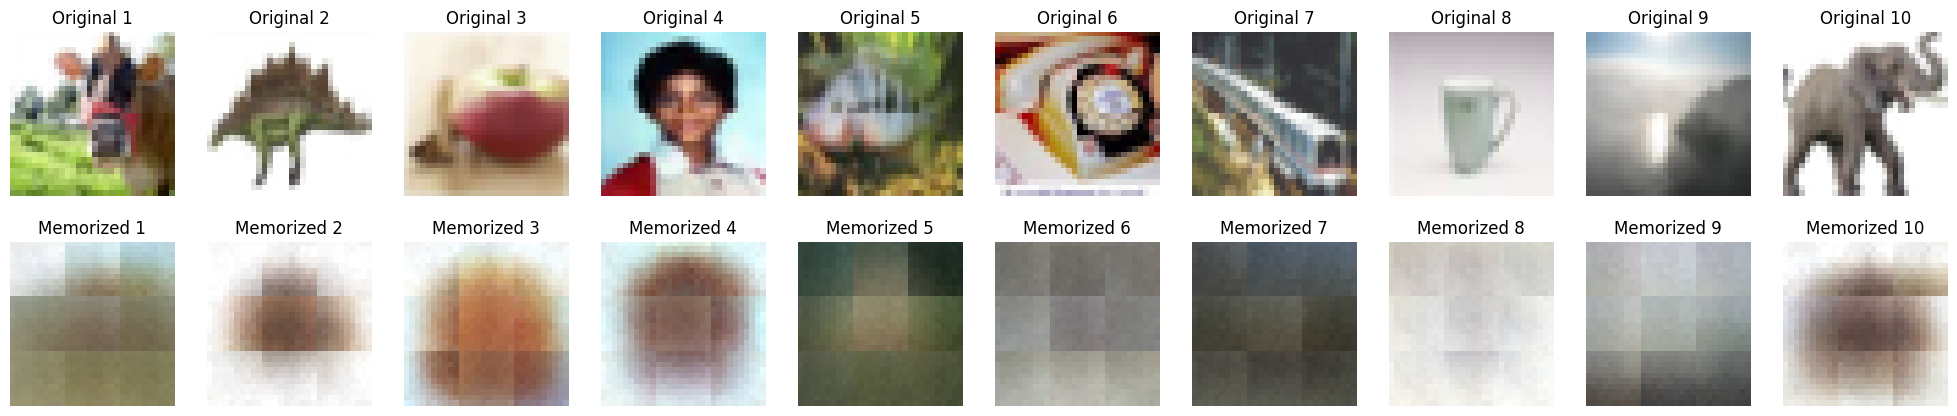

Epoch 126 | Cls Loss: 0.032240 | Mem Loss: 0.187410 | Accuracy: 0.301247 | Duration: 55.59 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1874
Epoch 127 | Cls Loss: 0.032311 | Mem Loss: 0.186721 | Accuracy: 0.302350 | Duration: 55.33 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1867
Epoch 128 | Cls Loss: 0.031447 | Mem Loss: 0.186164 | Accuracy: 0.325855 | Duration: 55.23 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1862
Epoch 129 | Cls Loss: 0.032122 | Mem Loss: 0.186530 | Accuracy: 0.305235 | Duration: 55.09 sec | Mem Loader Resets: 0
Epoch 130 | Cls Loss: 0.031901 | Mem Loss: 0.181377 | Accuracy: 0.308911 | Duration: 55.51 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.1814
Epoch 131 | Cls Loss: 0.031917 | Mem Loss: 0.179799 | Accuracy: 0.312632 | Duration: 55.39 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1798
Epoch 1

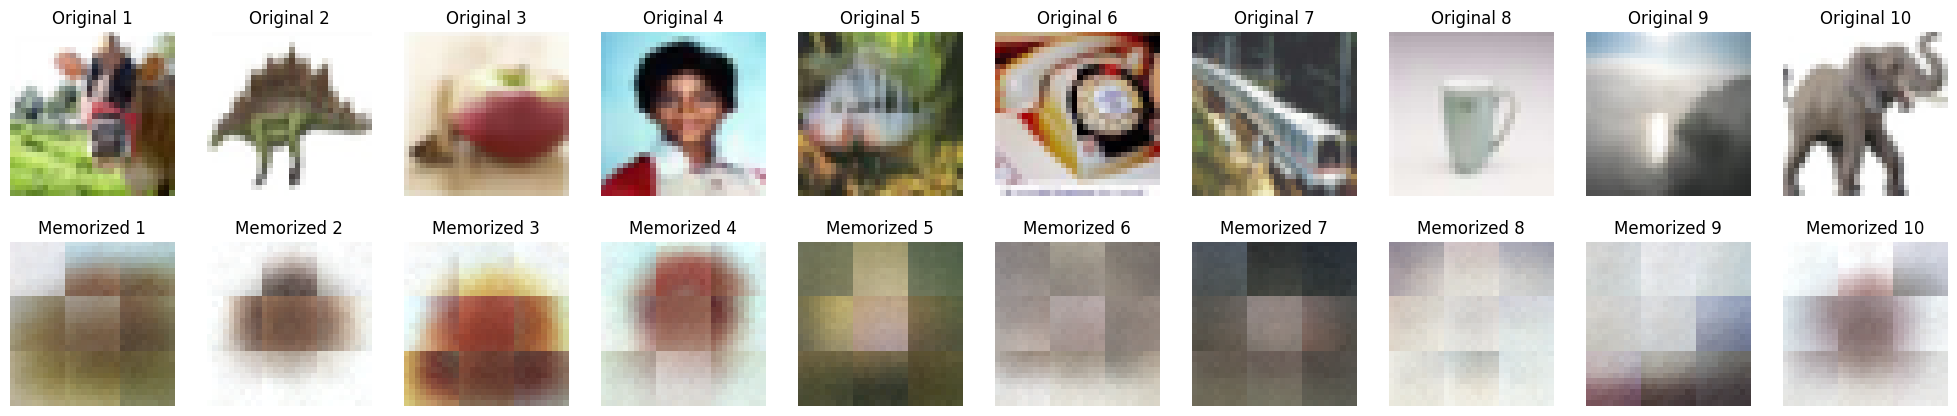

Epoch 151 | Cls Loss: 0.030844 | Mem Loss: 0.169743 | Accuracy: 0.341089 | Duration: 54.83 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1697
Epoch 152 | Cls Loss: 0.030313 | Mem Loss: 0.162358 | Accuracy: 0.354144 | Duration: 54.87 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.1624
Epoch 153 | Cls Loss: 0.030694 | Mem Loss: 0.163269 | Accuracy: 0.347123 | Duration: 54.89 sec | Mem Loader Resets: 0
Epoch 154 | Cls Loss: 0.030253 | Mem Loss: 0.163465 | Accuracy: 0.364254 | Duration: 55.09 sec | Mem Loader Resets: 0
Epoch 155 | Cls Loss: 0.031074 | Mem Loss: 0.162727 | Accuracy: 0.339166 | Duration: 55.25 sec | Mem Loader Resets: 0
Epoch 156 | Cls Loss: 0.030888 | Mem Loss: 0.163390 | Accuracy: 0.346340 | Duration: 55.12 sec | Mem Loader Resets: 0
Epoch 157 | Cls Loss: 0.030848 | Mem Loss: 0.163731 | Accuracy: 0.347586 | Duration: 54.94 sec | Mem Loader Resets: 0
Epoch 158 | Cls Loss: 0.030519 | Mem Loss: 0.162864 | Accura

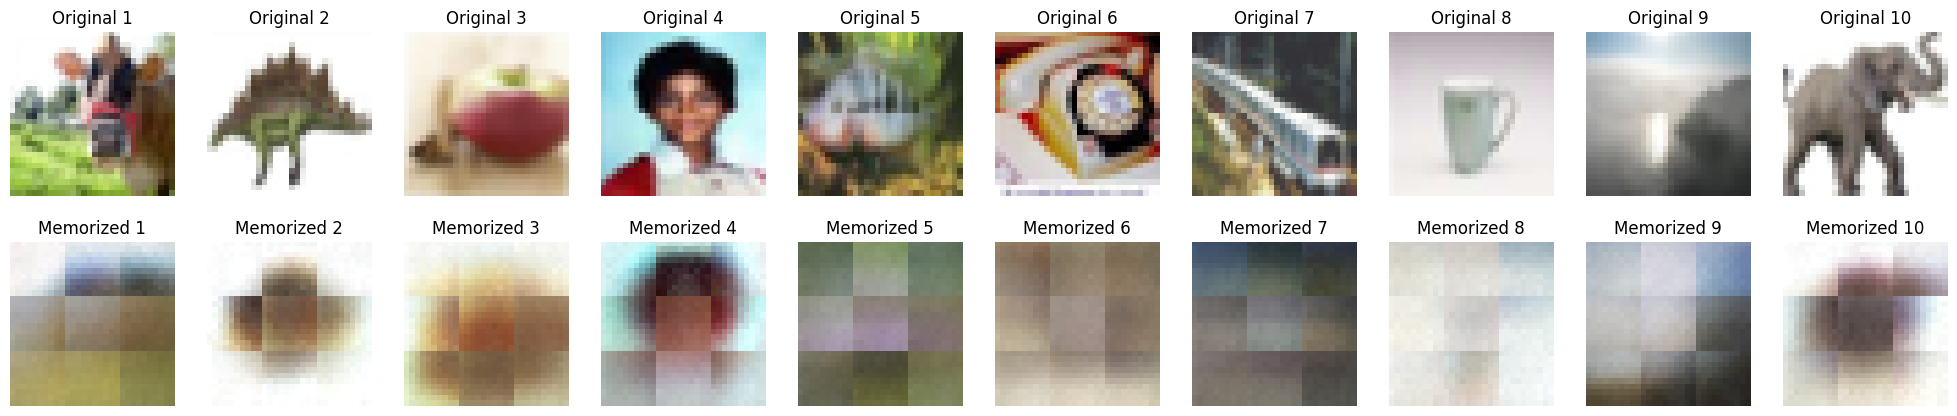

Epoch 176 | Cls Loss: 0.029911 | Mem Loss: 0.149938 | Accuracy: 0.378381 | Duration: 55.27 sec | Mem Loader Resets: 0
Epoch 177 | Cls Loss: 0.029403 | Mem Loss: 0.151198 | Accuracy: 0.386641 | Duration: 54.97 sec | Mem Loader Resets: 0
Epoch 178 | Cls Loss: 0.029833 | Mem Loss: 0.150516 | Accuracy: 0.361361 | Duration: 55.16 sec | Mem Loader Resets: 0
Epoch 179 | Cls Loss: 0.029898 | Mem Loss: 0.150258 | Accuracy: 0.370396 | Duration: 55.13 sec | Mem Loader Resets: 0
Epoch 180 | Cls Loss: 0.029676 | Mem Loss: 0.149992 | Accuracy: 0.365997 | Duration: 55.28 sec | Mem Loader Resets: 0
Epoch 181 | Cls Loss: 0.030122 | Mem Loss: 0.150818 | Accuracy: 0.372279 | Duration: 54.97 sec | Mem Loader Resets: 0
Epoch 182 | Cls Loss: 0.029242 | Mem Loss: 0.149856 | Accuracy: 0.387108 | Duration: 55.07 sec | Mem Loader Resets: 0
Epoch 183 | Cls Loss: 0.029365 | Mem Loss: 0.149926 | Accuracy: 0.386269 | Duration: 55.46 sec | Mem Loader Resets: 0
Epoch 184 | Cls Loss: 0.029898 | Mem Loss: 0.145279 | Ac

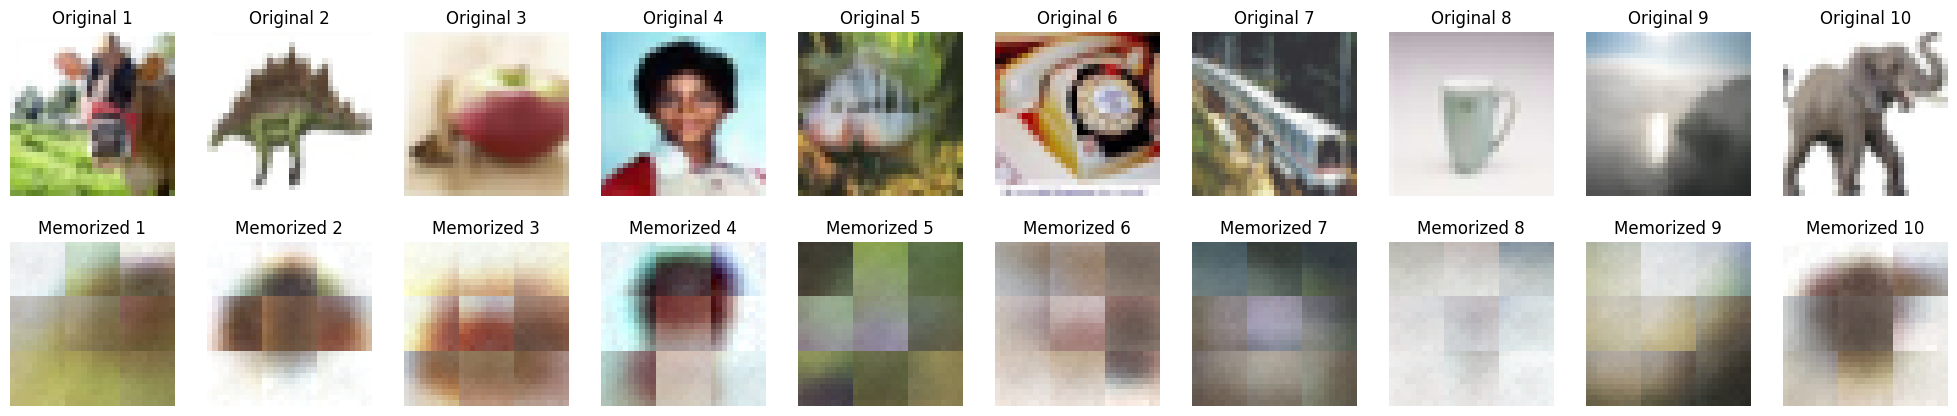

Epoch 201 | Cls Loss: 0.028907 | Mem Loss: 0.140388 | Accuracy: 0.393258 | Duration: 54.84 sec | Mem Loader Resets: 0
Epoch 202 | Cls Loss: 0.028749 | Mem Loss: 0.139755 | Accuracy: 0.403121 | Duration: 54.85 sec | Mem Loader Resets: 0
Epoch 203 | Cls Loss: 0.028874 | Mem Loss: 0.140011 | Accuracy: 0.394881 | Duration: 54.99 sec | Mem Loader Resets: 0
Epoch 204 | Cls Loss: 0.028737 | Mem Loss: 0.140230 | Accuracy: 0.408144 | Duration: 54.91 sec | Mem Loader Resets: 0
Epoch 205 | Cls Loss: 0.028912 | Mem Loss: 0.139757 | Accuracy: 0.402430 | Duration: 55.34 sec | Mem Loader Resets: 0
Epoch 206 | Cls Loss: 0.028824 | Mem Loss: 0.133454 | Accuracy: 0.404959 | Duration: 54.87 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.1335
Epoch 207 | Cls Loss: 0.028392 | Mem Loss: 0.133548 | Accuracy: 0.412496 | Duration: 55.10 sec | Mem Loader Resets: 0
Epoch 208 | Cls Loss: 0.029206 | Mem Loss: 0.134035 | Accuracy: 0.388027 | Duration: 54.86 sec | Mem Loader Resets: 0

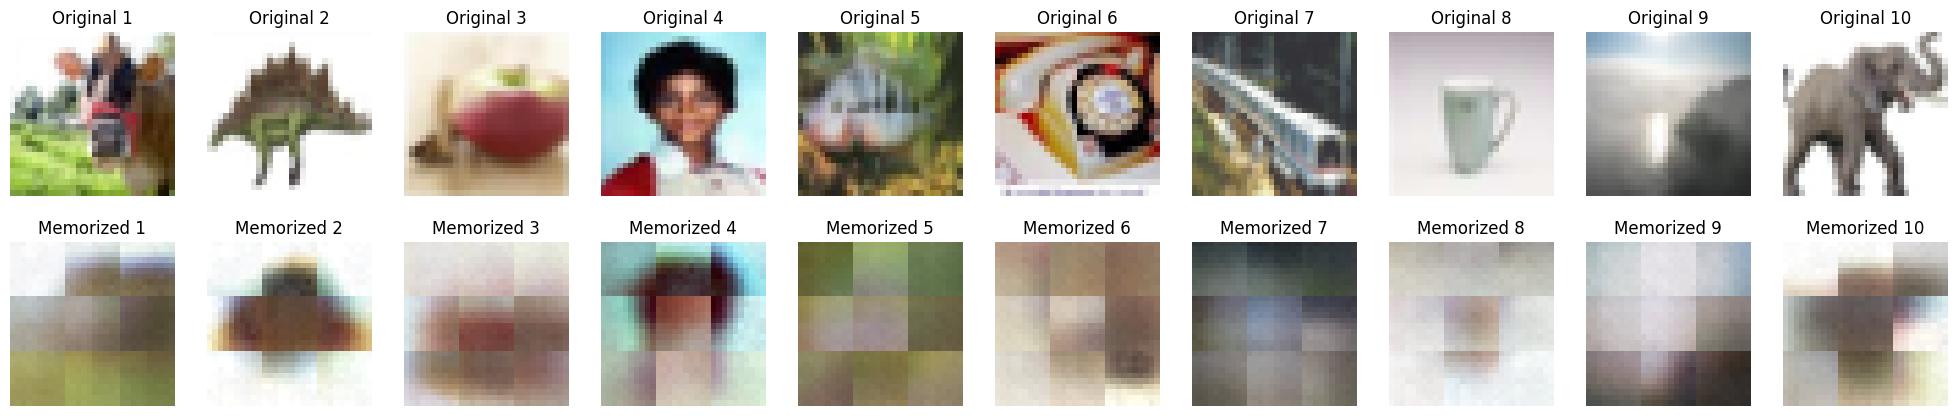

Epoch 226 | Cls Loss: 0.027654 | Mem Loss: 0.131182 | Accuracy: 0.433520 | Duration: 54.85 sec | Mem Loader Resets: 0
Epoch 227 | Cls Loss: 0.028032 | Mem Loss: 0.128743 | Accuracy: 0.415781 | Duration: 54.99 sec | Mem Loader Resets: 1
Epoch 228 | Cls Loss: 0.027925 | Mem Loss: 0.124548 | Accuracy: 0.434427 | Duration: 55.15 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1245
Epoch 229 | Cls Loss: 0.028054 | Mem Loss: 0.125650 | Accuracy: 0.434343 | Duration: 54.87 sec | Mem Loader Resets: 0
Epoch 230 | Cls Loss: 0.027950 | Mem Loss: 0.125916 | Accuracy: 0.428928 | Duration: 54.56 sec | Mem Loader Resets: 0
Epoch 231 | Cls Loss: 0.027566 | Mem Loss: 0.126667 | Accuracy: 0.439606 | Duration: 55.11 sec | Mem Loader Resets: 0
Epoch 232 | Cls Loss: 0.028117 | Mem Loss: 0.127141 | Accuracy: 0.425531 | Duration: 54.96 sec | Mem Loader Resets: 0
Epoch 233 | Cls Loss: 0.028233 | Mem Loss: 0.127000 | Accuracy: 0.421160 | Duration: 54.94 sec | Mem Loader Resets: 0

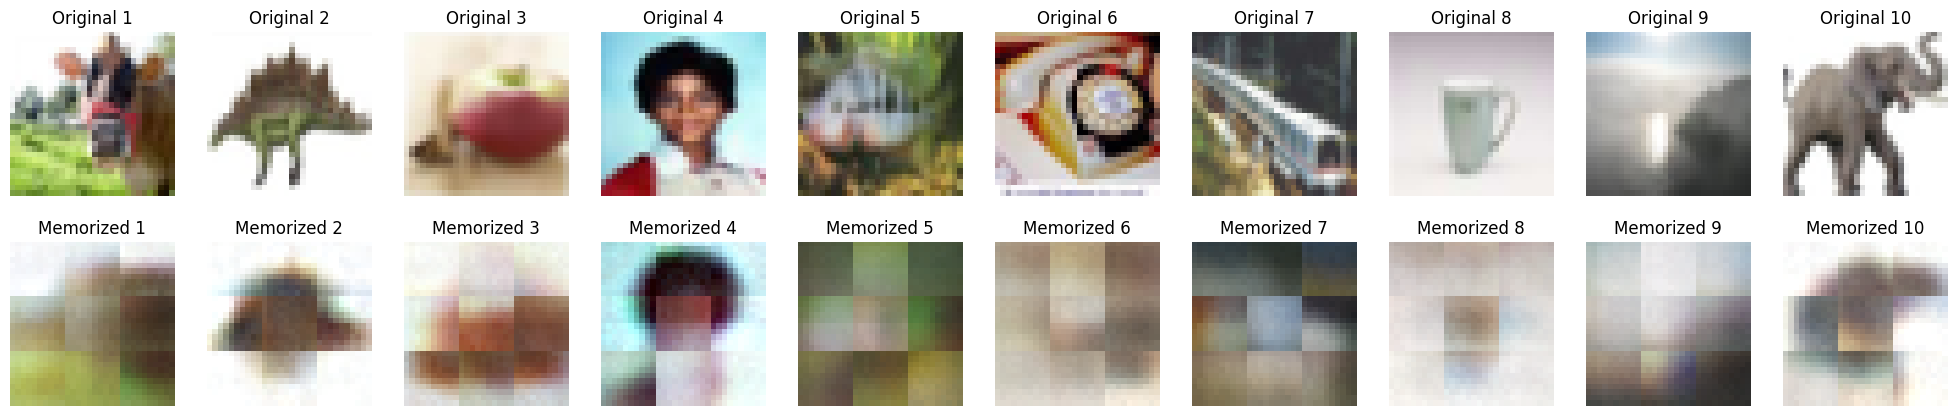

Epoch 251 | Cls Loss: 0.026904 | Mem Loss: 0.119239 | Accuracy: 0.448793 | Duration: 54.89 sec | Mem Loader Resets: 0
Epoch 252 | Cls Loss: 0.026938 | Mem Loss: 0.119396 | Accuracy: 0.455215 | Duration: 55.14 sec | Mem Loader Resets: 0
Epoch 253 | Cls Loss: 0.027707 | Mem Loss: 0.119797 | Accuracy: 0.442447 | Duration: 55.05 sec | Mem Loader Resets: 0
Epoch 254 | Cls Loss: 0.026857 | Mem Loss: 0.119604 | Accuracy: 0.458212 | Duration: 54.77 sec | Mem Loader Resets: 0
Epoch 255 | Cls Loss: 0.027131 | Mem Loss: 0.120310 | Accuracy: 0.448006 | Duration: 54.76 sec | Mem Loader Resets: 0
Epoch 256 | Cls Loss: 0.027161 | Mem Loss: 0.120471 | Accuracy: 0.451391 | Duration: 55.20 sec | Mem Loader Resets: 0
Epoch 257 | Cls Loss: 0.027668 | Mem Loss: 0.120434 | Accuracy: 0.440022 | Duration: 54.86 sec | Mem Loader Resets: 0
Epoch 258 | Cls Loss: 0.027446 | Mem Loss: 0.120741 | Accuracy: 0.444921 | Duration: 54.87 sec | Mem Loader Resets: 0
Epoch 259 | Cls Loss: 0.026732 | Mem Loss: 0.120441 | Ac

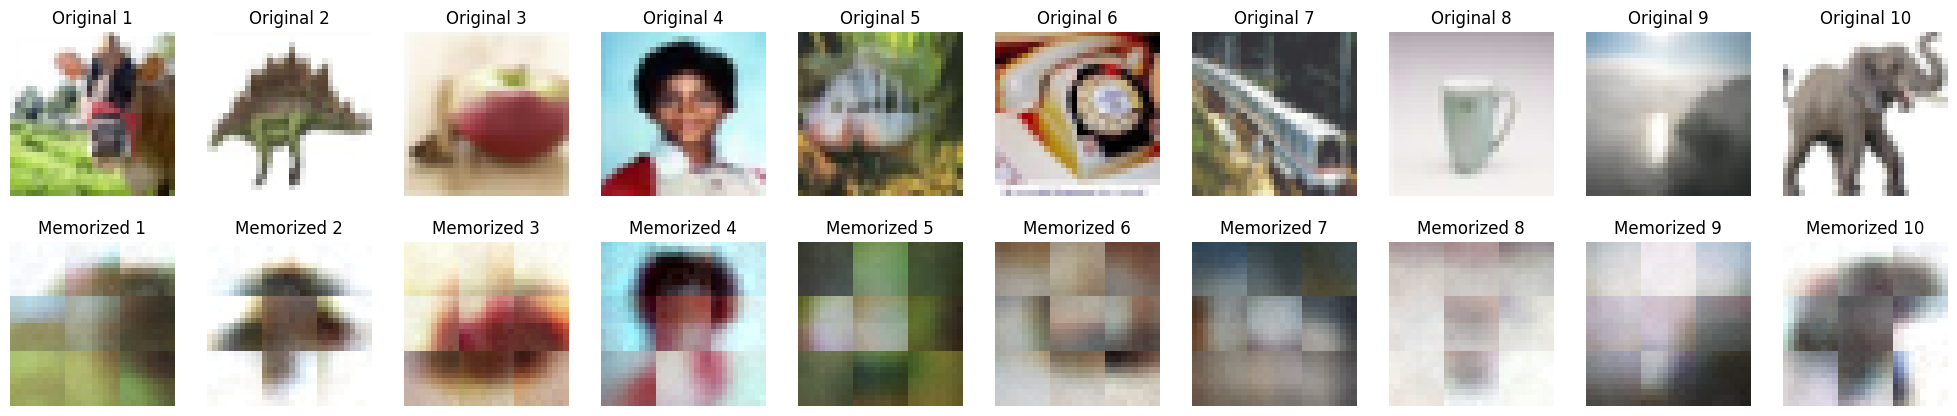

Epoch 276 | Cls Loss: 0.026964 | Mem Loss: 0.113788 | Accuracy: 0.462500 | Duration: 55.07 sec | Mem Loader Resets: 0
Epoch 277 | Cls Loss: 0.026488 | Mem Loss: 0.114295 | Accuracy: 0.464262 | Duration: 55.02 sec | Mem Loader Resets: 0
Epoch 278 | Cls Loss: 0.026696 | Mem Loss: 0.113702 | Accuracy: 0.469002 | Duration: 55.41 sec | Mem Loader Resets: 0
Epoch 279 | Cls Loss: 0.027116 | Mem Loss: 0.114162 | Accuracy: 0.449936 | Duration: 55.25 sec | Mem Loader Resets: 0
Epoch 280 | Cls Loss: 0.026603 | Mem Loss: 0.115172 | Accuracy: 0.459811 | Duration: 55.17 sec | Mem Loader Resets: 0
Epoch 281 | Cls Loss: 0.026771 | Mem Loss: 0.111780 | Accuracy: 0.456550 | Duration: 54.94 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.1118
Epoch 282 | Cls Loss: 0.026594 | Mem Loss: 0.109228 | Accuracy: 0.473134 | Duration: 55.00 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1092
Epoch 283 | Cls Loss: 0.026533 | Mem Loss: 0.109875 | Accura

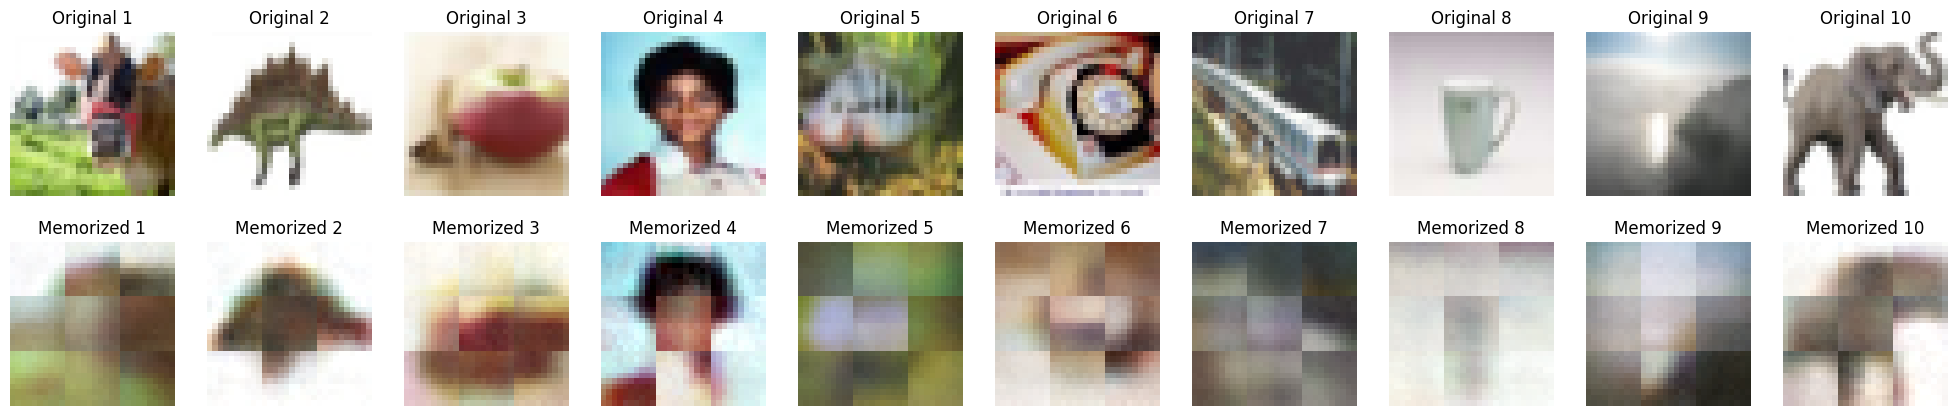

Epoch 301 | Cls Loss: 0.025817 | Mem Loss: 0.109460 | Accuracy: 0.496623 | Duration: 54.84 sec | Mem Loader Resets: 0
Epoch 302 | Cls Loss: 0.026153 | Mem Loss: 0.109485 | Accuracy: 0.490693 | Duration: 54.95 sec | Mem Loader Resets: 0
Epoch 303 | Cls Loss: 0.026129 | Mem Loss: 0.105077 | Accuracy: 0.486273 | Duration: 55.07 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.1051
Epoch 304 | Cls Loss: 0.026155 | Mem Loss: 0.103980 | Accuracy: 0.473601 | Duration: 55.06 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.1040
Epoch 305 | Cls Loss: 0.025415 | Mem Loss: 0.104920 | Accuracy: 0.500639 | Duration: 54.73 sec | Mem Loader Resets: 0
Epoch 306 | Cls Loss: 0.025702 | Mem Loss: 0.105527 | Accuracy: 0.494293 | Duration: 55.10 sec | Mem Loader Resets: 0
Epoch 307 | Cls Loss: 0.025415 | Mem Loss: 0.105602 | Accuracy: 0.494473 | Duration: 55.03 sec | Mem Loader Resets: 0
Epoch 308 | Cls Loss: 0.025595 | Mem Loss: 0.106149 | Accura

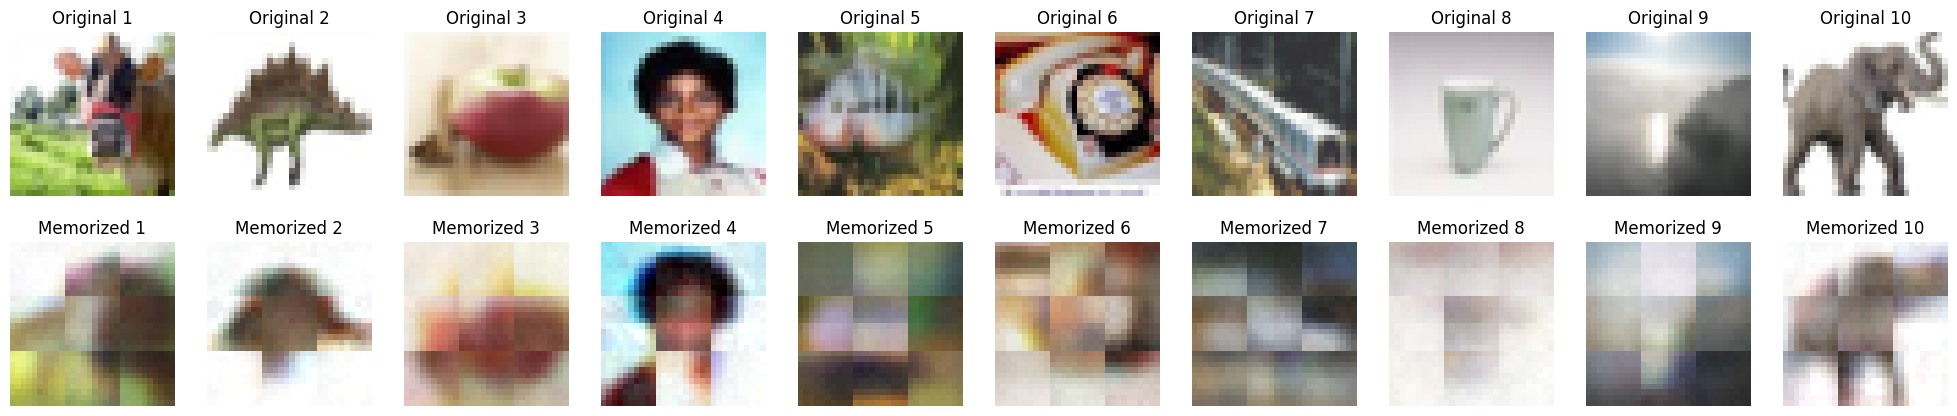

Epoch 326 | Cls Loss: 0.025675 | Mem Loss: 0.099895 | Accuracy: 0.488871 | Duration: 54.97 sec | Mem Loader Resets: 0
Epoch 327 | Cls Loss: 0.026131 | Mem Loss: 0.099778 | Accuracy: 0.480595 | Duration: 55.16 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.0998
Epoch 328 | Cls Loss: 0.025458 | Mem Loss: 0.100825 | Accuracy: 0.498473 | Duration: 55.02 sec | Mem Loader Resets: 0
Epoch 329 | Cls Loss: 0.024874 | Mem Loss: 0.100979 | Accuracy: 0.501658 | Duration: 55.25 sec | Mem Loader Resets: 0
Epoch 330 | Cls Loss: 0.025633 | Mem Loss: 0.101186 | Accuracy: 0.497950 | Duration: 54.92 sec | Mem Loader Resets: 0
Epoch 331 | Cls Loss: 0.026156 | Mem Loss: 0.101823 | Accuracy: 0.473869 | Duration: 55.52 sec | Mem Loader Resets: 0
Epoch 332 | Cls Loss: 0.025480 | Mem Loss: 0.101983 | Accuracy: 0.501774 | Duration: 55.10 sec | Mem Loader Resets: 0
Epoch 333 | Cls Loss: 0.025370 | Mem Loss: 0.101893 | Accuracy: 0.498637 | Duration: 55.21 sec | Mem Loader Resets: 0

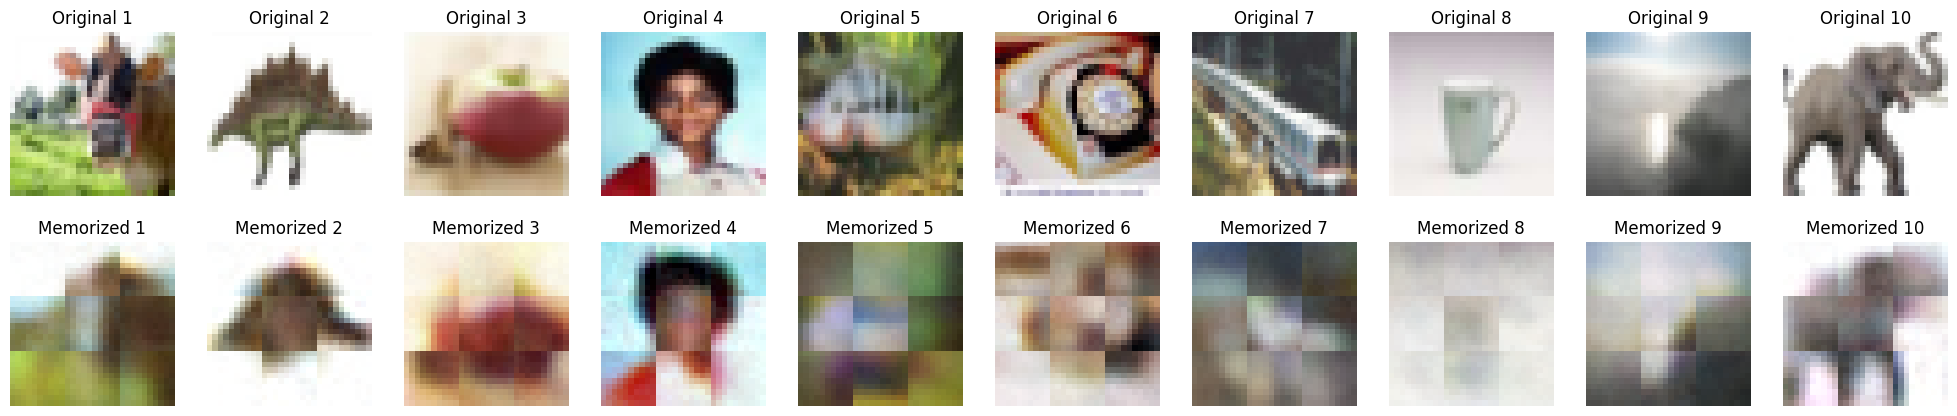

Epoch 351 | Cls Loss: 0.024851 | Mem Loss: 0.097481 | Accuracy: 0.521575 | Duration: 55.28 sec | Mem Loader Resets: 0
Epoch 352 | Cls Loss: 0.024757 | Mem Loss: 0.097765 | Accuracy: 0.517803 | Duration: 55.52 sec | Mem Loader Resets: 0
Epoch 353 | Cls Loss: 0.025088 | Mem Loss: 0.097371 | Accuracy: 0.500811 | Duration: 55.41 sec | Mem Loader Resets: 0
Epoch 354 | Cls Loss: 0.024935 | Mem Loss: 0.097358 | Accuracy: 0.523889 | Duration: 55.04 sec | Mem Loader Resets: 0
Epoch 355 | Cls Loss: 0.024861 | Mem Loss: 0.098144 | Accuracy: 0.516412 | Duration: 54.77 sec | Mem Loader Resets: 0
Epoch 356 | Cls Loss: 0.024914 | Mem Loss: 0.097356 | Accuracy: 0.517931 | Duration: 55.02 sec | Mem Loader Resets: 0
Epoch 357 | Cls Loss: 0.024330 | Mem Loss: 0.093611 | Accuracy: 0.529676 | Duration: 55.02 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.0936
Epoch 358 | Cls Loss: 0.024776 | Mem Loss: 0.093662 | Accuracy: 0.524129 | Duration: 54.93 sec | Mem Loader Resets: 0

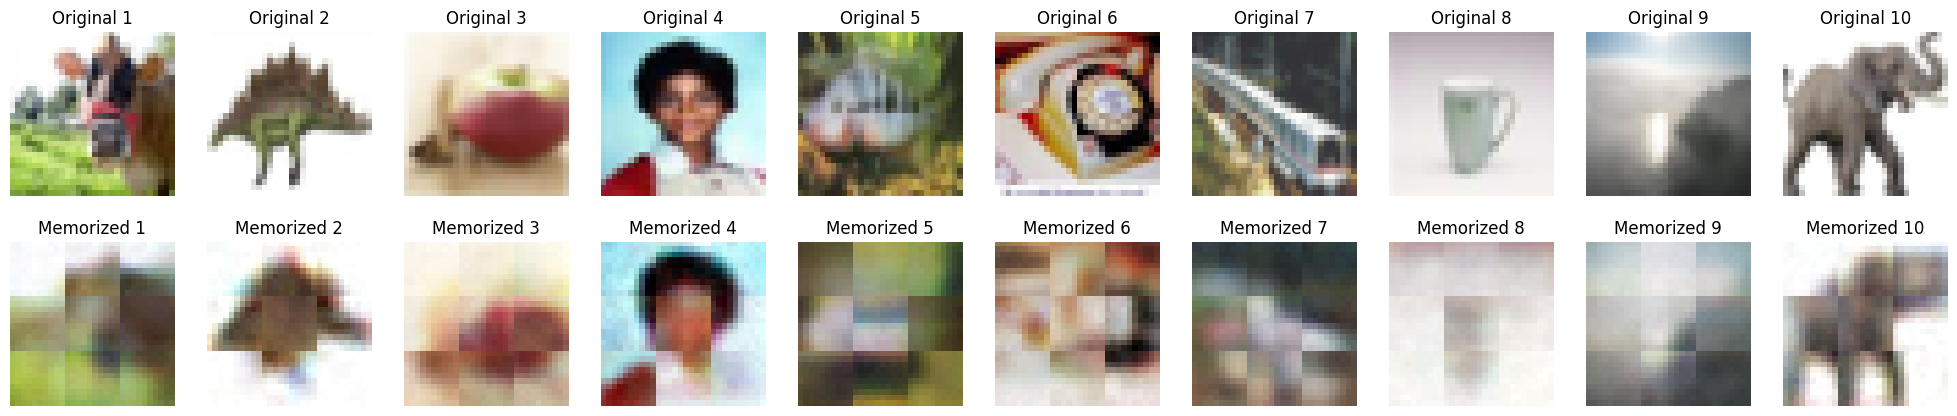

Epoch 376 | Cls Loss: 0.024695 | Mem Loss: 0.093530 | Accuracy: 0.528013 | Duration: 55.27 sec | Mem Loader Resets: 0
Epoch 377 | Cls Loss: 0.024354 | Mem Loss: 0.094107 | Accuracy: 0.534059 | Duration: 54.95 sec | Mem Loader Resets: 0
Epoch 378 | Cls Loss: 0.024331 | Mem Loss: 0.092483 | Accuracy: 0.538371 | Duration: 55.08 sec | Mem Loader Resets: 1
Epoch 379 | Cls Loss: 0.024834 | Mem Loss: 0.089848 | Accuracy: 0.520404 | Duration: 55.59 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.0898
Epoch 380 | Cls Loss: 0.025180 | Mem Loss: 0.089372 | Accuracy: 0.509467 | Duration: 55.06 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.0894
Epoch 381 | Cls Loss: 0.024729 | Mem Loss: 0.089693 | Accuracy: 0.526806 | Duration: 54.93 sec | Mem Loader Resets: 0
Epoch 382 | Cls Loss: 0.024683 | Mem Loss: 0.090371 | Accuracy: 0.528225 | Duration: 55.00 sec | Mem Loader Resets: 0
Epoch 383 | Cls Loss: 0.025013 | Mem Loss: 0.091108 | Accura

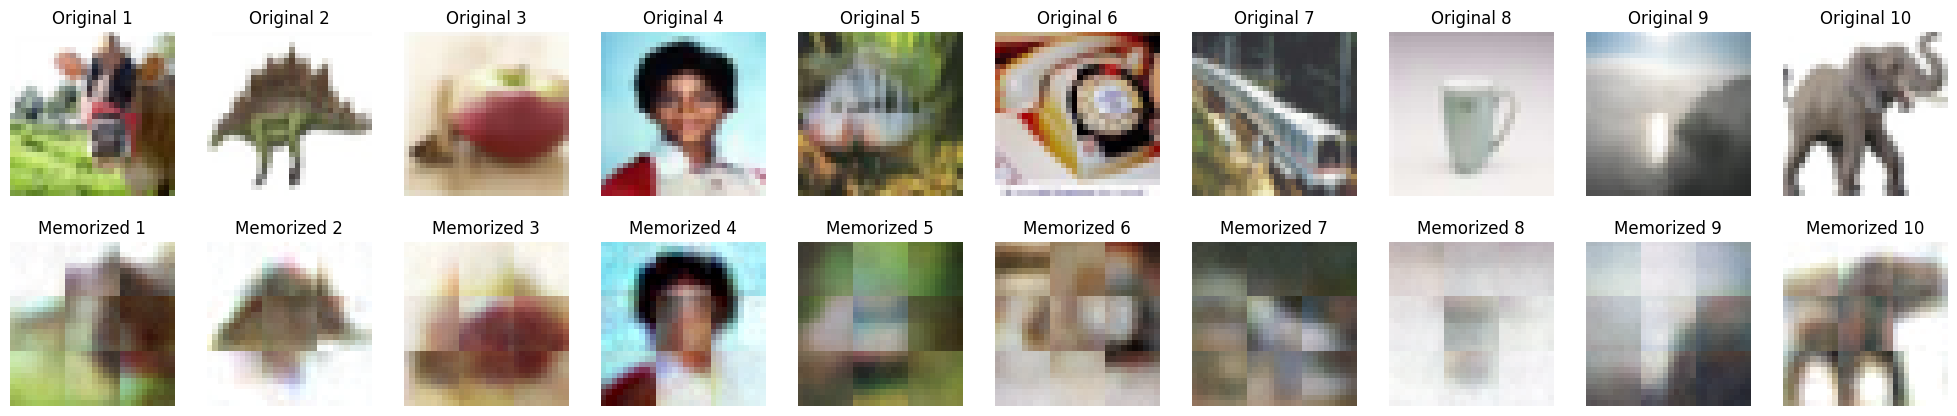

Epoch 401 | Cls Loss: 0.024211 | Mem Loss: 0.085700 | Accuracy: 0.534323 | Duration: 55.55 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.0857
Epoch 402 | Cls Loss: 0.024788 | Mem Loss: 0.086401 | Accuracy: 0.534319 | Duration: 54.96 sec | Mem Loader Resets: 0
Epoch 403 | Cls Loss: 0.024172 | Mem Loss: 0.086866 | Accuracy: 0.543490 | Duration: 55.37 sec | Mem Loader Resets: 0
Epoch 404 | Cls Loss: 0.024127 | Mem Loss: 0.087173 | Accuracy: 0.548222 | Duration: 55.42 sec | Mem Loader Resets: 0
Epoch 405 | Cls Loss: 0.024823 | Mem Loss: 0.087637 | Accuracy: 0.525771 | Duration: 54.82 sec | Mem Loader Resets: 0
Epoch 406 | Cls Loss: 0.024212 | Mem Loss: 0.087967 | Accuracy: 0.550176 | Duration: 55.08 sec | Mem Loader Resets: 0
Epoch 407 | Cls Loss: 0.023564 | Mem Loss: 0.087935 | Accuracy: 0.557101 | Duration: 54.96 sec | Mem Loader Resets: 0
Epoch 408 | Cls Loss: 0.024578 | Mem Loss: 0.088029 | Accuracy: 0.526099 | Duration: 55.41 sec | Mem Loader Resets: 0

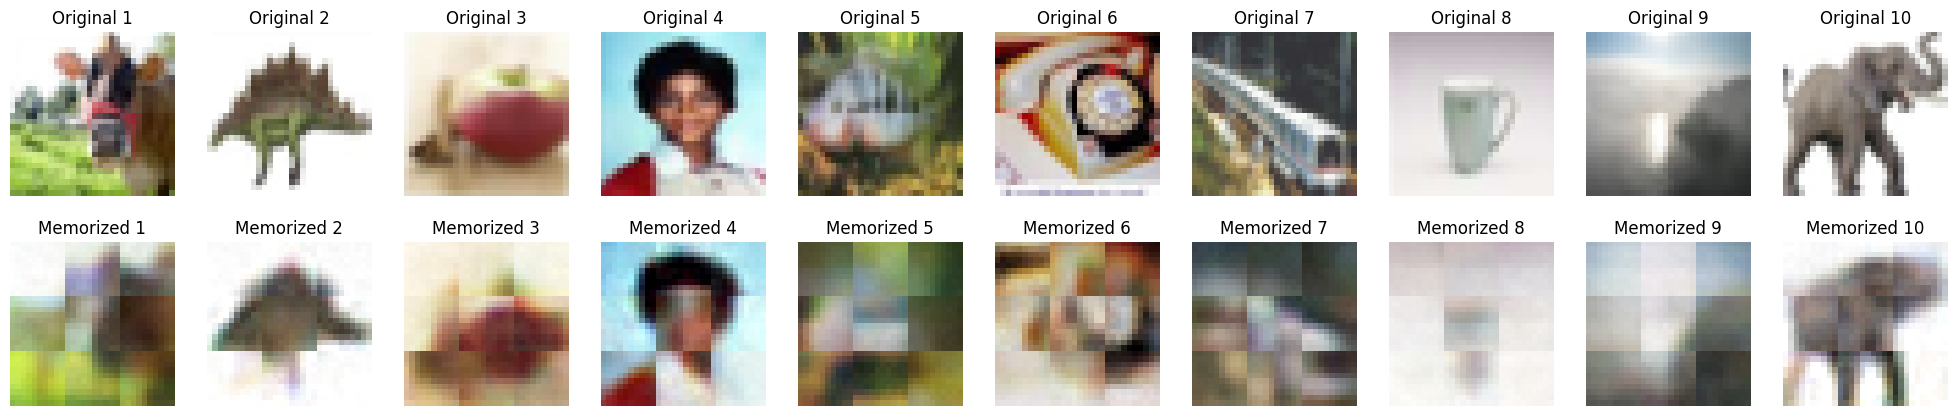

Epoch 426 | Cls Loss: 0.024092 | Mem Loss: 0.084108 | Accuracy: 0.543822 | Duration: 54.96 sec | Mem Loader Resets: 0
Epoch 427 | Cls Loss: 0.024509 | Mem Loss: 0.084740 | Accuracy: 0.530263 | Duration: 54.94 sec | Mem Loader Resets: 0
Epoch 428 | Cls Loss: 0.023550 | Mem Loss: 0.084783 | Accuracy: 0.559003 | Duration: 54.87 sec | Mem Loader Resets: 0
Epoch 429 | Cls Loss: 0.023863 | Mem Loss: 0.084800 | Accuracy: 0.541568 | Duration: 55.53 sec | Mem Loader Resets: 0
Epoch 430 | Cls Loss: 0.023833 | Mem Loss: 0.084944 | Accuracy: 0.562136 | Duration: 54.84 sec | Mem Loader Resets: 0
Epoch 431 | Cls Loss: 0.023772 | Mem Loss: 0.085176 | Accuracy: 0.550951 | Duration: 54.83 sec | Mem Loader Resets: 0
Epoch 432 | Cls Loss: 0.023936 | Mem Loss: 0.083699 | Accuracy: 0.548406 | Duration: 54.80 sec | Mem Loader Resets: 1
Epoch 433 | Cls Loss: 0.023694 | Mem Loss: 0.081218 | Accuracy: 0.556358 | Duration: 54.56 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.0812

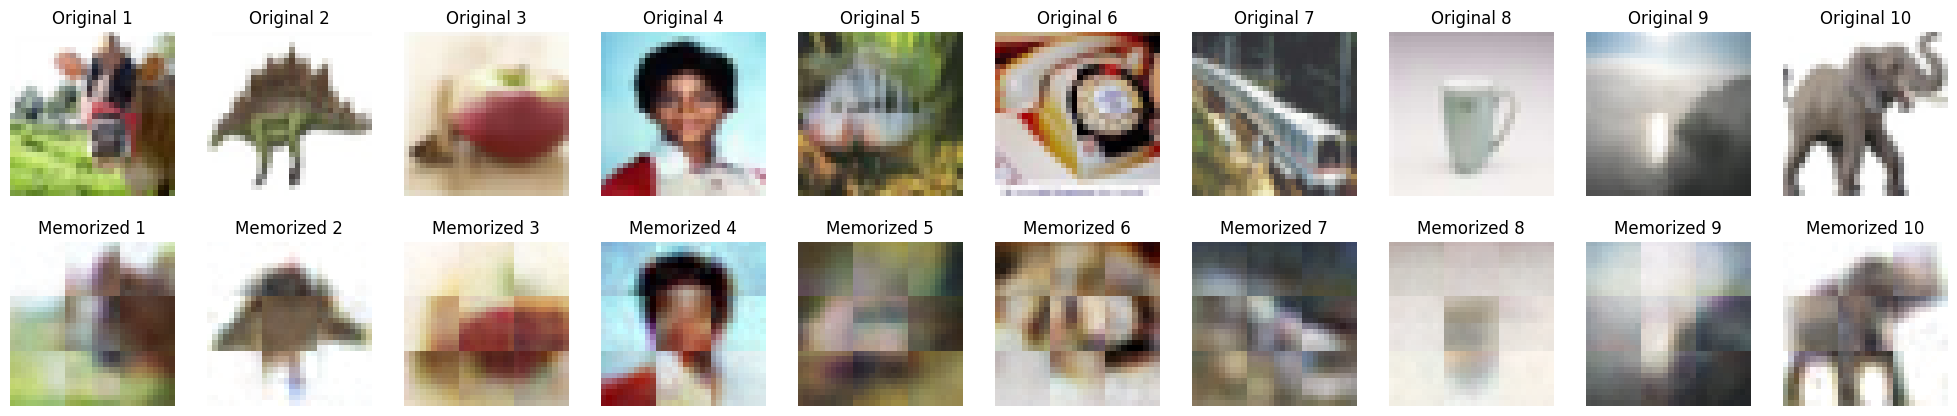

Epoch 451 | Cls Loss: 0.023673 | Mem Loss: 0.082104 | Accuracy: 0.556841 | Duration: 54.82 sec | Mem Loader Resets: 0
Epoch 452 | Cls Loss: 0.023972 | Mem Loss: 0.082327 | Accuracy: 0.539722 | Duration: 54.95 sec | Mem Loader Resets: 0
Epoch 453 | Cls Loss: 0.023527 | Mem Loss: 0.082188 | Accuracy: 0.565429 | Duration: 55.11 sec | Mem Loader Resets: 0
Epoch 454 | Cls Loss: 0.023680 | Mem Loss: 0.079099 | Accuracy: 0.570968 | Duration: 55.06 sec | Mem Loader Resets: 1
Saved model and optimizer with memorization loss: 0.0791
Epoch 455 | Cls Loss: 0.023417 | Mem Loss: 0.078650 | Accuracy: 0.551527 | Duration: 54.70 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.0786
Epoch 456 | Cls Loss: 0.023622 | Mem Loss: 0.079273 | Accuracy: 0.555251 | Duration: 55.28 sec | Mem Loader Resets: 0
Epoch 457 | Cls Loss: 0.023540 | Mem Loss: 0.079566 | Accuracy: 0.560718 | Duration: 54.58 sec | Mem Loader Resets: 0
Epoch 458 | Cls Loss: 0.023419 | Mem Loss: 0.079754 | Accura

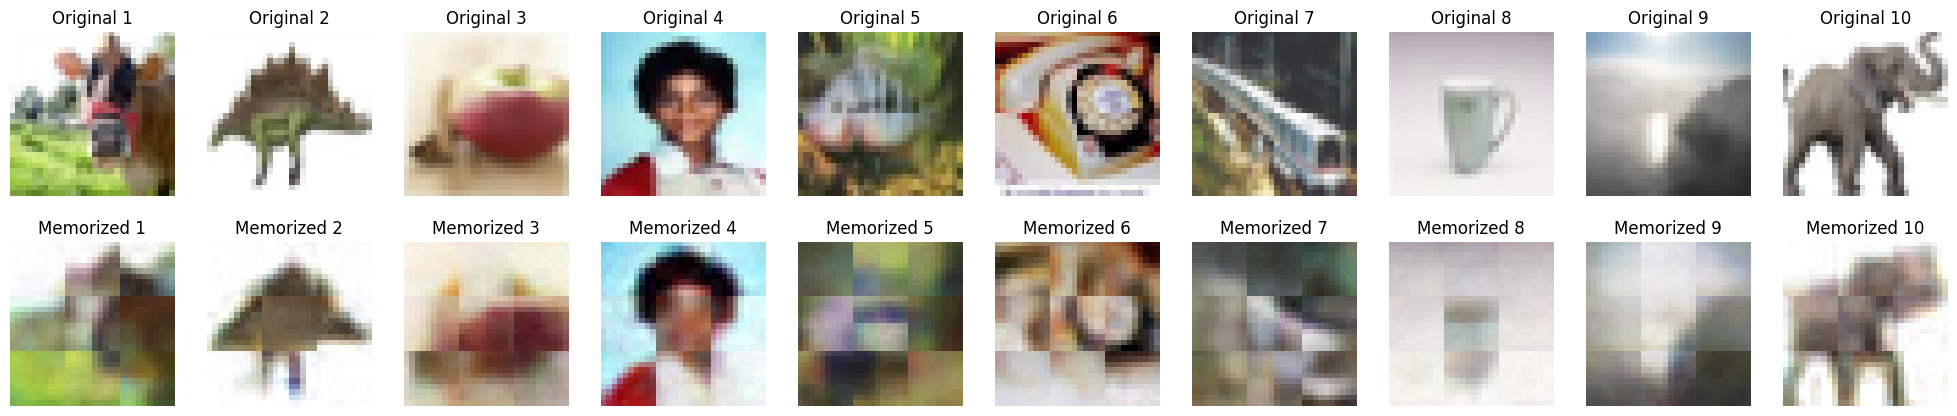

Epoch 476 | Cls Loss: 0.024270 | Mem Loss: 0.076038 | Accuracy: 0.533200 | Duration: 54.83 sec | Mem Loader Resets: 0
Saved model and optimizer with memorization loss: 0.0760
Epoch 477 | Cls Loss: 0.023158 | Mem Loss: 0.076436 | Accuracy: 0.564906 | Duration: 54.79 sec | Mem Loader Resets: 0
Epoch 478 | Cls Loss: 0.023354 | Mem Loss: 0.076351 | Accuracy: 0.550488 | Duration: 54.81 sec | Mem Loader Resets: 0
Epoch 479 | Cls Loss: 0.022958 | Mem Loss: 0.077423 | Accuracy: 0.574285 | Duration: 54.84 sec | Mem Loader Resets: 0
Epoch 480 | Cls Loss: 0.022888 | Mem Loss: 0.077240 | Accuracy: 0.589954 | Duration: 54.95 sec | Mem Loader Resets: 0
Epoch 481 | Cls Loss: 0.023183 | Mem Loss: 0.077536 | Accuracy: 0.568462 | Duration: 55.01 sec | Mem Loader Resets: 0
Epoch 482 | Cls Loss: 0.023465 | Mem Loss: 0.077875 | Accuracy: 0.568966 | Duration: 54.88 sec | Mem Loader Resets: 0
Epoch 483 | Cls Loss: 0.023387 | Mem Loss: 0.078173 | Accuracy: 0.566952 | Duration: 55.08 sec | Mem Loader Resets: 0

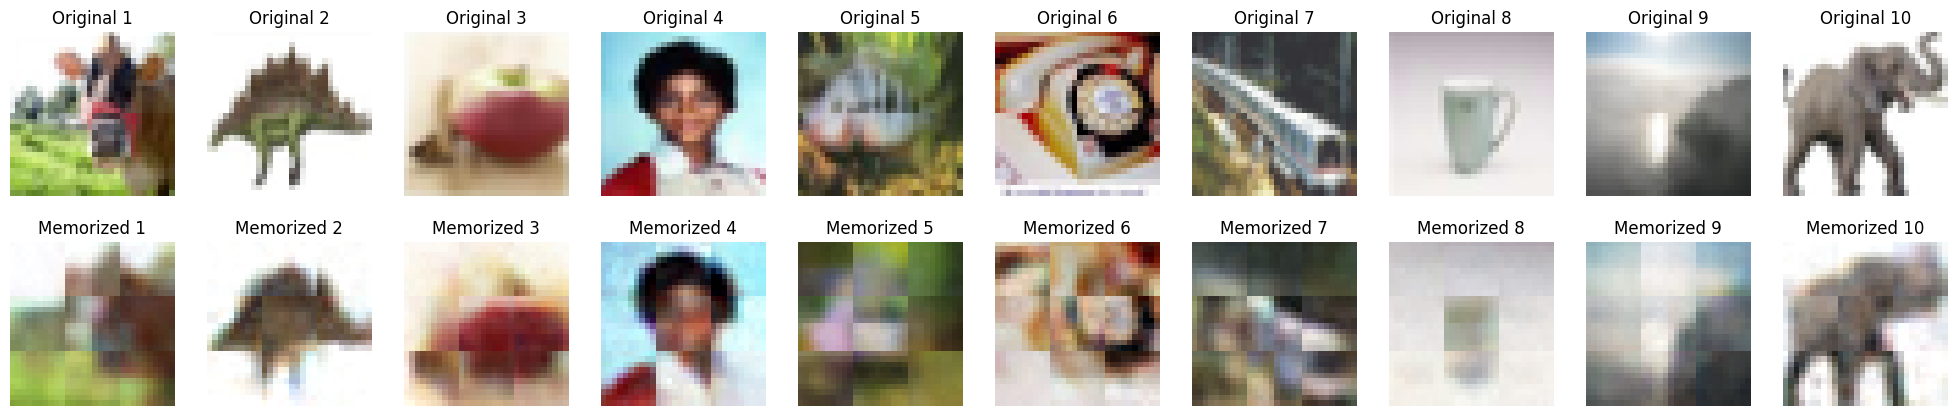

Total training time: 07:41:28 (hh:mm:ss)


In [38]:
def train(model, train_loader_cls, mem_dataloader, epochs, device, warmup_epochs=10):
    model.to(device)
     
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()
    
    log = []
    mem_iterator = iter(mem_dataloader)
    best_mem_loss = float('inf')

    training_start_time = time.time() 

    for epoch in range(epochs):
        mem_loader_reset_count = 0
        start_time = time.time()
        epoch_stats = {'mem_loss': 0, 'cls_loss': 0, 'accuracy': 0, 'counter': 0}

        
        if epoch < 10:
            memorization_loss_weight = 0
        else:
            memorization_loss_weight = 1


        for data, cls_labels in train_loader_cls:
            try:
                codes, mem_targets, channels = next(mem_iterator)
            except StopIteration:
                mem_iterator = iter(mem_dataloader)
                codes, mem_targets, channels = next(mem_iterator)
                mem_loader_reset_count += 1 

            optimizer.zero_grad()
            
            data, cls_labels = data.to(device), cls_labels.to(device)
            codes, mem_targets = codes.to(device), mem_targets.to(device)

            # Correctly calculate target_channel
            batch_indices = torch.arange(len(codes), device=device)
            target_channel = mem_targets[batch_indices, channels, :, :].unsqueeze(1)
            current_batch_size = target_channel.size(0)
            target_channel = target_channel.view(current_batch_size, -1)

            # Apply augmentations for the classification task
            if hparams['cutmix'] or hparams['mixup']:
                lam = 1.0
                targets_a, targets_b = cls_labels, cls_labels
                
                if hparams['cutmix']:
                    data, targets_a, targets_b, lam_cutmix = CutMix(size=32, beta=1.0)((data, cls_labels))
                    lam = lam_cutmix
                
                if hparams['mixup']:
                    if np.random.rand() <= 0.8:
                        data, targets_a, targets_b, lam_mixup = MixUp(alpha=1.0)((data, cls_labels))
                    else:
                        targets_a, targets_b, lam_mixup = cls_labels, torch.zeros_like(cls_labels), 1.0
                    lam = lam_mixup if not hparams['cutmix'] else (lam + lam_mixup) / 2

                cls_outputs = model(data)
                cls_loss = lam * ce_loss(cls_outputs, targets_a) + (1 - lam) * ce_loss(cls_outputs, targets_b)
            else:
                cls_outputs = model(data)
                cls_loss = ce_loss(cls_outputs, cls_labels)

            # cls_outputs = model(data)
            # cls_loss = ce_loss(cls_outputs, cls_labels)
            cls_loss = CLASSIFICATION_LOSS_WEIGHT * cls_loss

            mem_outputs = model(codes)[:, :PATCH_SIZE**2]
            # mem_loss = mse_loss(mem_outputs, target_channel)

            mem_mse_loss = mse_loss(mem_outputs, target_channel)
            mem_mae_loss = mae_loss(mem_outputs, target_channel)
            mem_loss = mem_mse_loss + mem_mae_loss

            loss = cls_loss + memorization_loss_weight*mem_loss 
            loss.backward()
            optimizer.step()

            acc = calculate_accuracy(cls_outputs, cls_labels)
            epoch_stats['mem_loss'] += mem_loss.item()
            epoch_stats['cls_loss'] += cls_loss.item()
            epoch_stats['accuracy'] += acc
            epoch_stats['counter'] += 1

        epoch_stats['cls_loss'] /= epoch_stats['counter']
        epoch_stats['mem_loss'] /= epoch_stats['counter']
        epoch_stats['accuracy'] /= epoch_stats['counter']
        epoch_duration = time.time() - start_time

        print(f'Epoch {epoch + 1} | Cls Loss: {epoch_stats["cls_loss"]:.6f} | Mem Loss: {epoch_stats["mem_loss"]:.6f} | Accuracy: {epoch_stats["accuracy"]:.6f} | Duration: {epoch_duration:.2f} sec | Mem Loader Resets: {mem_loader_reset_count}')
        # scheduler.step()


        if epoch_stats['mem_loss'] < best_mem_loss:
            best_mem_loss = epoch_stats['mem_loss']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)
            print(f'Saved model and optimizer with memorization loss: {best_mem_loss:.4f}')
            
        # if (epoch + 1) % 50 == 0:
        #     epoch_model_path = os.path.join(directory_path, f"model_epoch_{epoch + 1}.pth")
        #     torch.save({
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'epoch': epoch + 1
        #     }, epoch_model_path)
        #     print(f'Saved model and optimizer at epoch {epoch + 1}')

        if (epoch + 1) % 25 == 0:
            print(f'Visualizing results at Epoch {epoch + 1}')
            visualize_results(model, device)

        log.append(epoch_stats)

    total_training_time = time.time() - training_start_time
    hours, remainder = divmod(total_training_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f'Total training time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss)')

    # pd.DataFrame(log).to_csv(LOG_FILE_PATH, index=False)

EPOCHS = 500
train(model, train_loader_cls, mem_dataloader, EPOCHS, device)


Evaluation

In [39]:
def load_model(model_path, model, optimizer, device):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model, optimizer

In [40]:
# MODEL_PATH = "models/12BLOCKS_3_0.1_500_CLASSIFICATION_LOSS_WEIGHT_0.1_0.0001_128_ADAMW_cifar100_vit.pth"
# #0.02 , 0.04 , 0.1 , 0.2

In [41]:
best_model, _ = load_model(MODEL_PATH, model, optimizer, device)

Test Accuracy

In [42]:
def test_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    model.to(device)  
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device) 
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    # print(correct)
    # print(total)
    # print(f'Accuracy of the model on the test images: {accuracy:.2f}')
    return accuracy

In [43]:
test_accuracy(best_model, test_loader_cls , device)

0.6242

In [44]:
def get_image(idx, model):
    mark_values = {0: 0.333, 1: 0.666, 2: 0.999}
    index_gray = mem_dataset.gray_codes[idx][0]
    class_gray = mem_dataset.gray_codes[idx][1]
    target_image = mem_dataset.target_images[idx]
    
    channel_batches = [torch.zeros(GRID_SIZE * GRID_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE) for _ in range(3)]
    
    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                input = torch.zeros(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
                input[0,:,:] = index_gray
                input[1,:,:] = class_gray
                input[2, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
                input[channel, -1:, 0:32] = mark_values[channel]
                channel_batches[channel][patch_index, :, :, :] = input
                patch_index += 1

    with torch.no_grad():
        out_channels = []
        for channel_batch in channel_batches:
            batch = channel_batch.float().to(device)
            outs = model(batch)[:, :PATCH_SIZE**2].view(-1, PATCH_SIZE, PATCH_SIZE)
            out_channels.append(outs)

    out_image = torch.zeros(3, GRID_SIZE * PATCH_SIZE, GRID_SIZE * PATCH_SIZE)
    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                out_image[channel, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = out_channels[channel][patch_index, :, :]
                patch_index += 1
                
    out_image_resized = F.interpolate(out_image.unsqueeze(0), size=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze(0)
    
    return out_image_resized, target_image.squeeze(0)

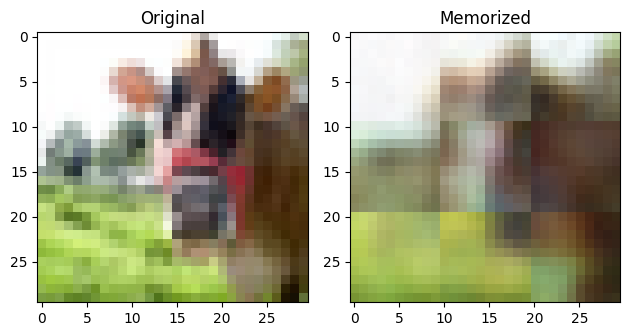

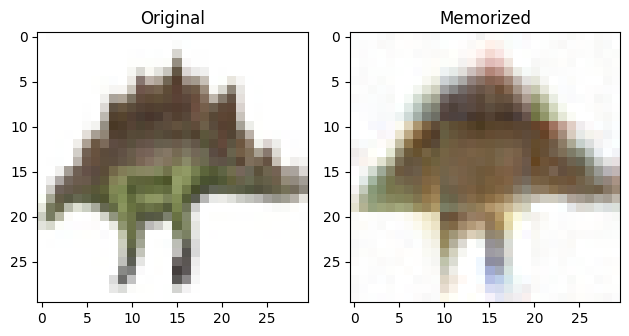

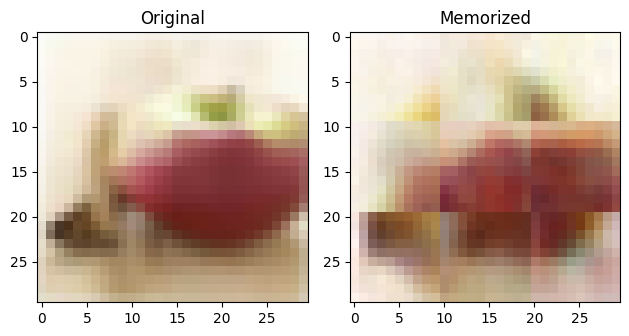

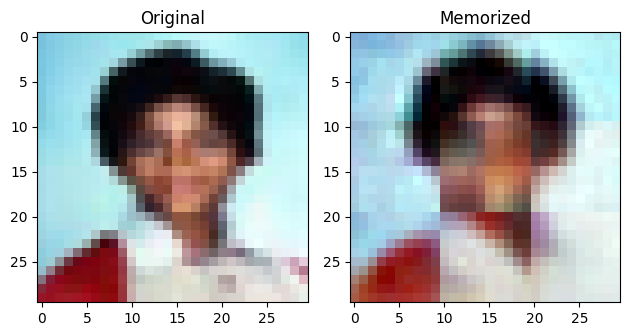

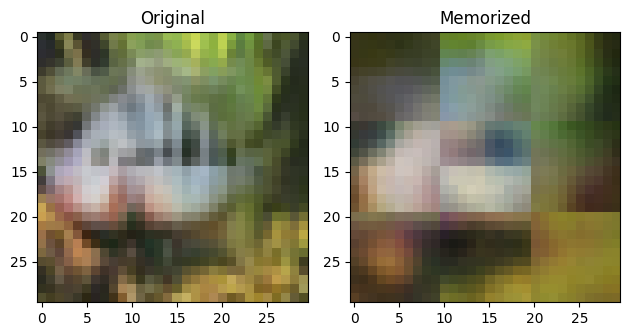

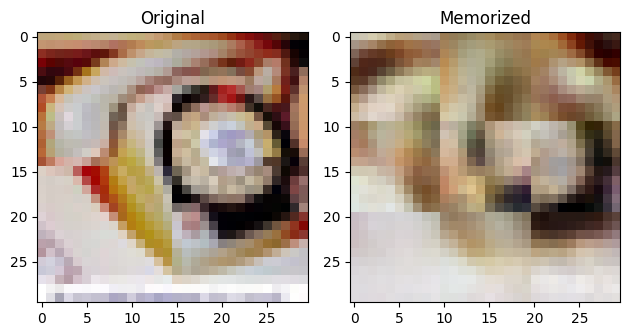

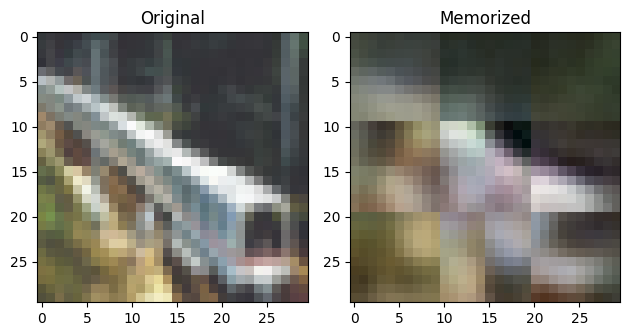

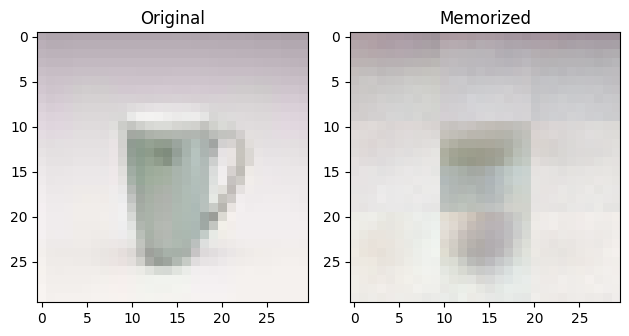

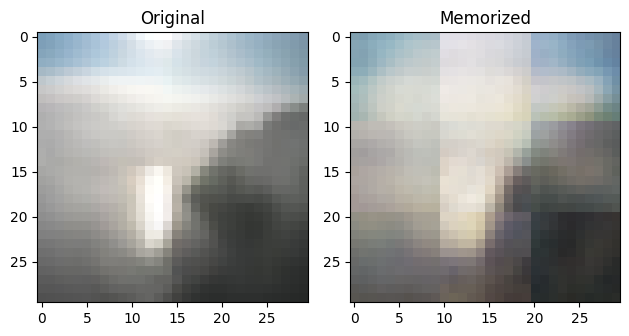

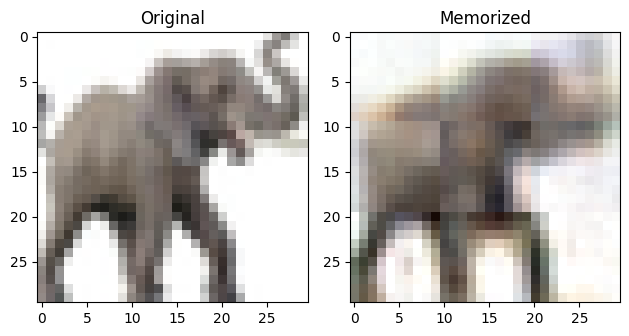

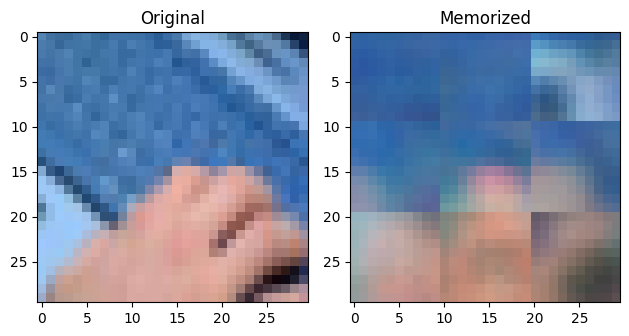

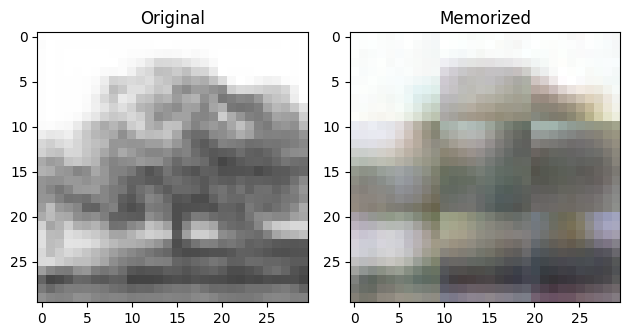

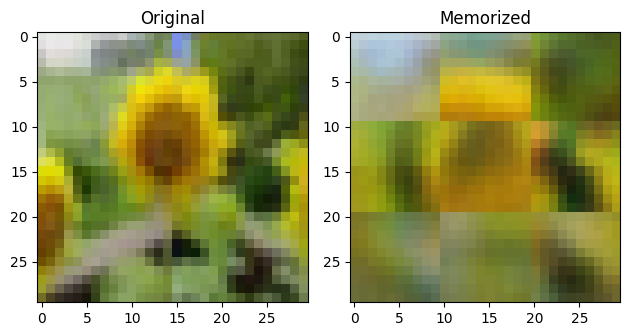

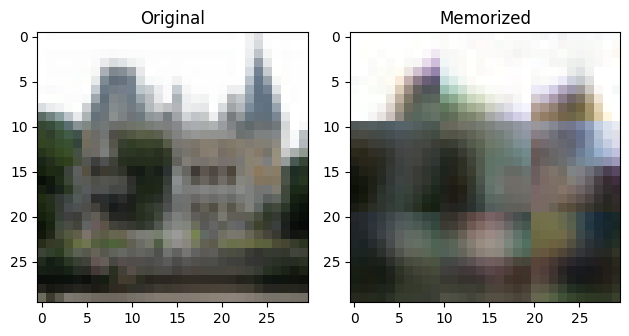

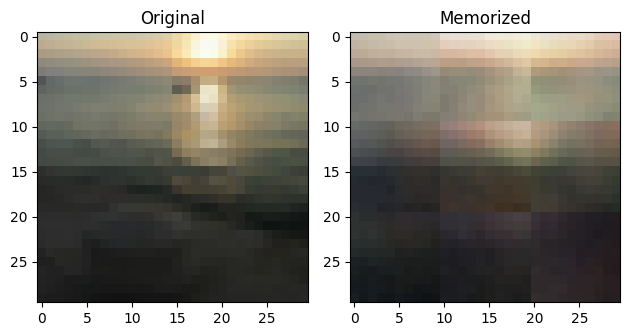

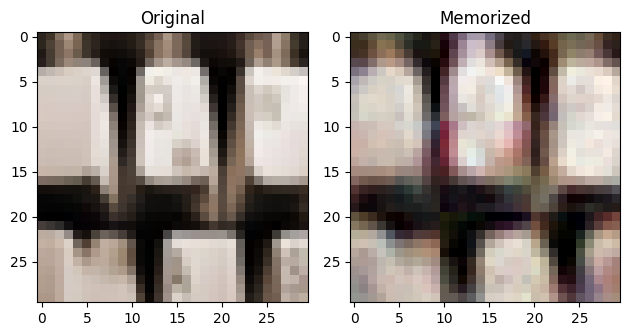

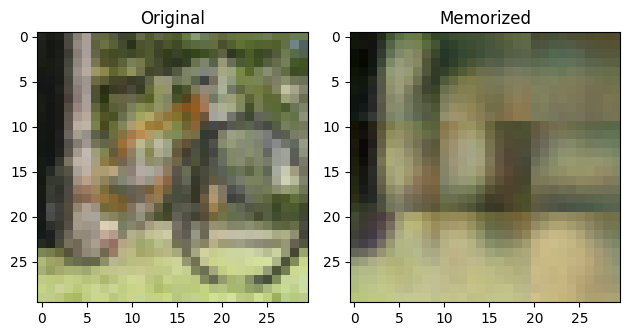

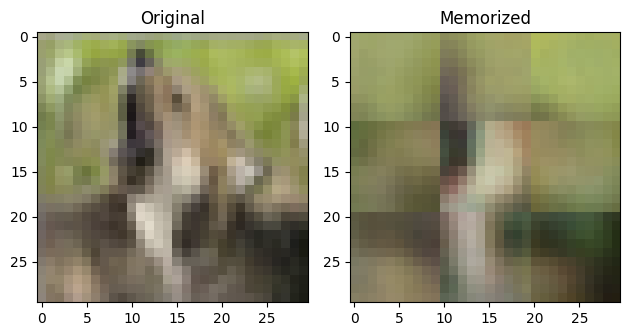

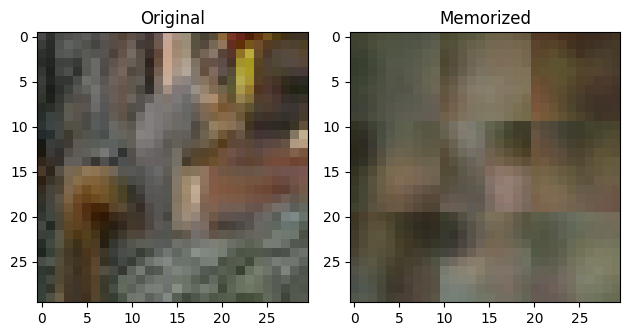

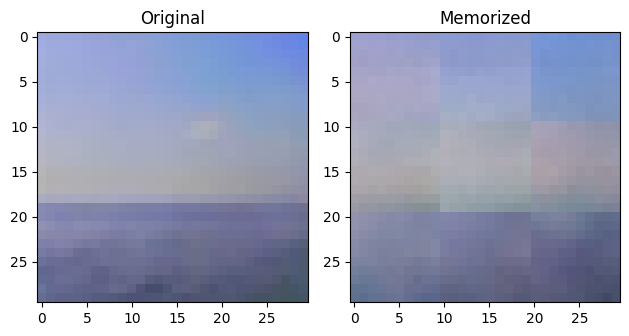

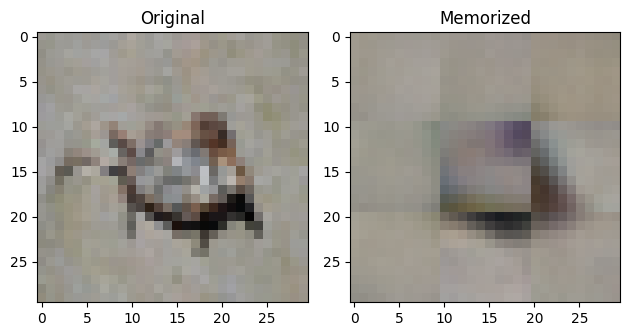

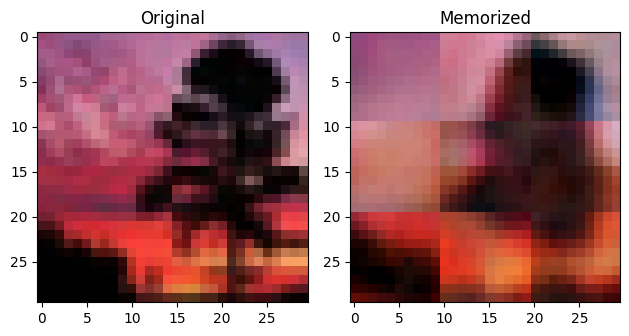

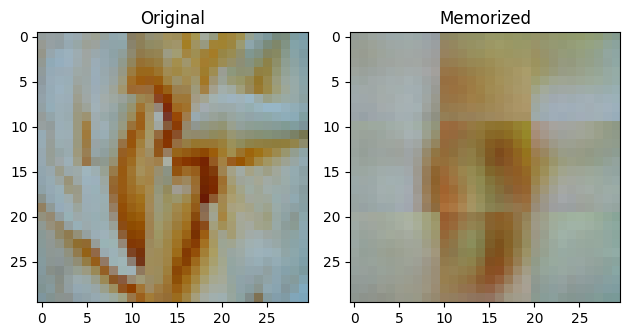

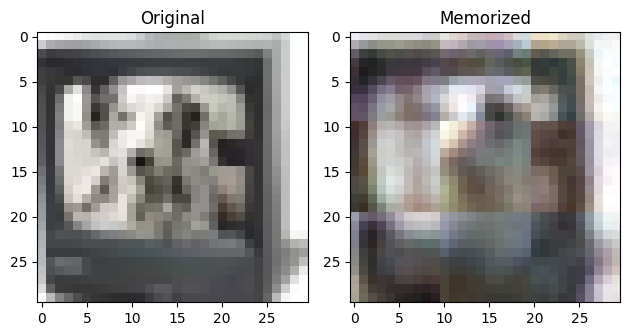

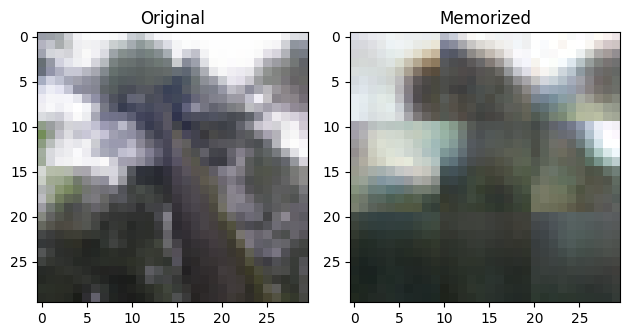

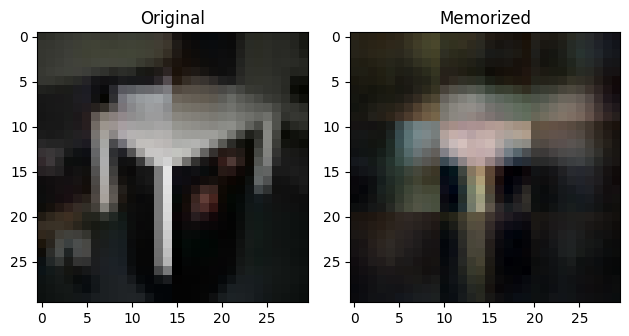

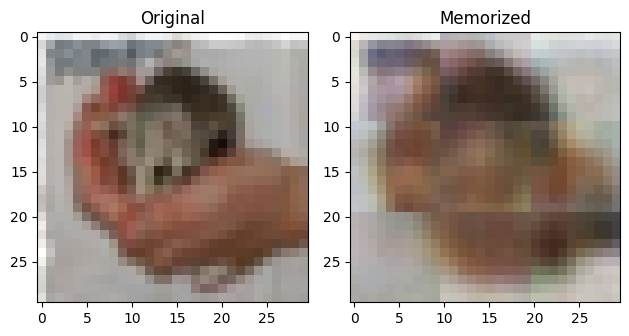

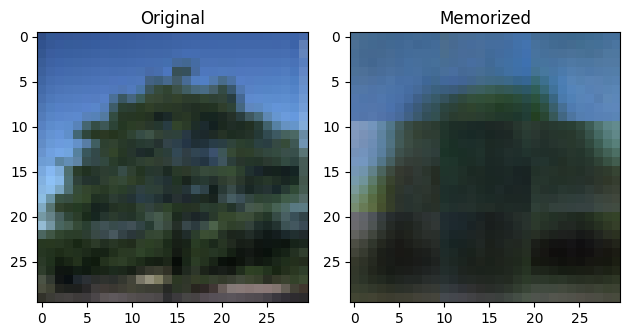

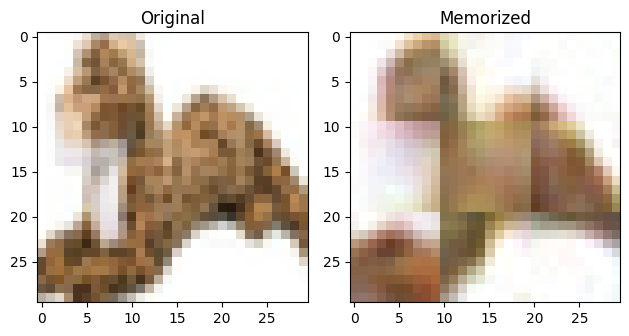

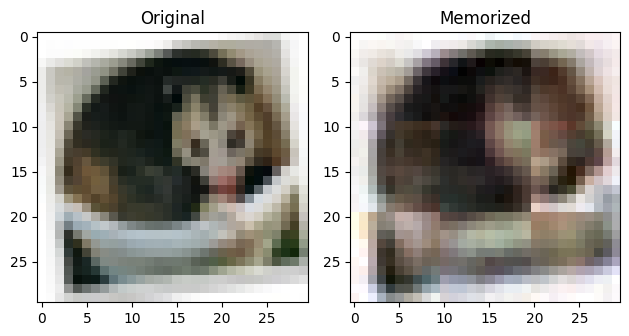

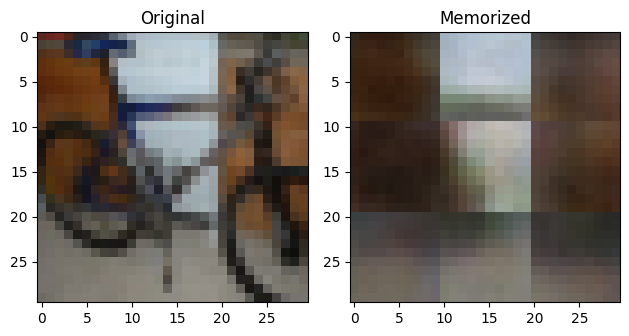

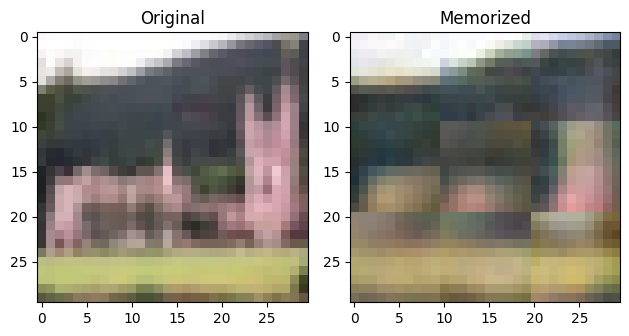

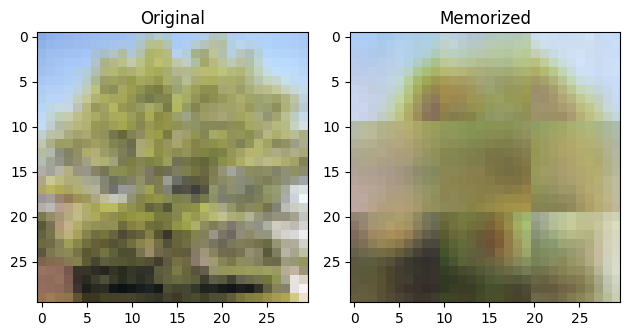

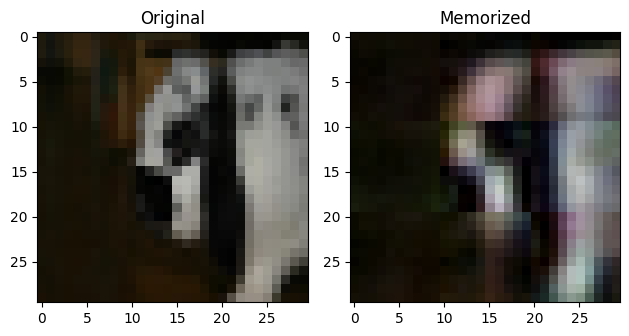

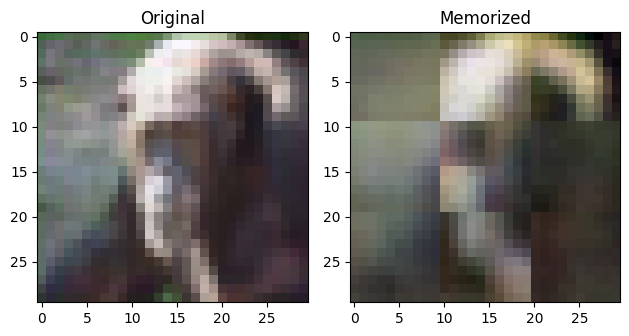

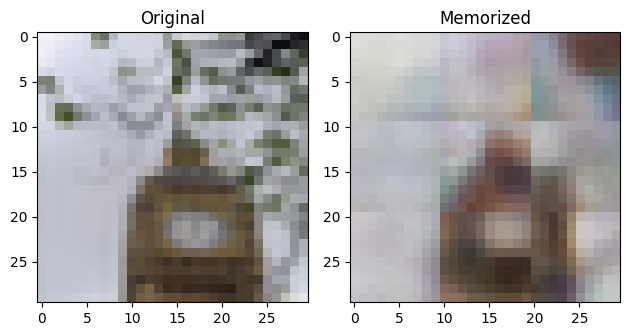

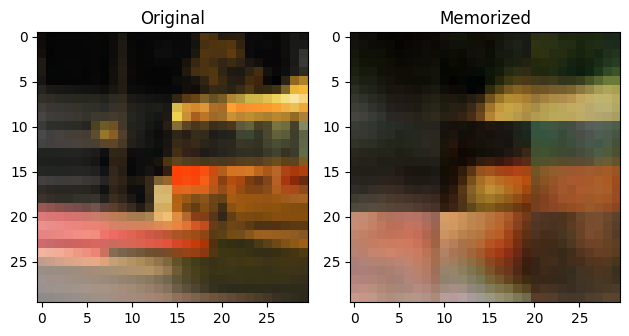

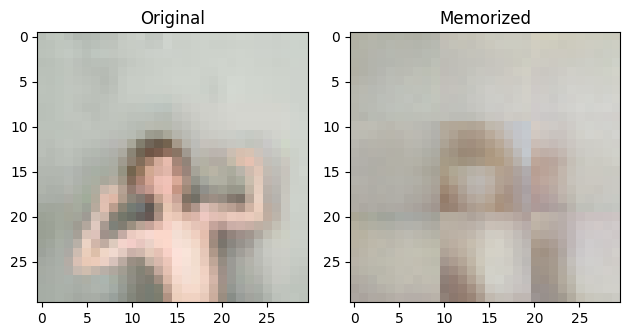

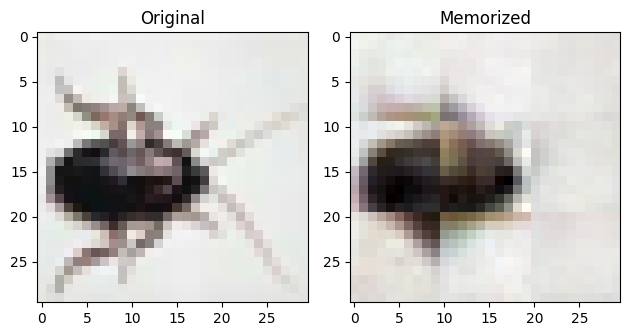

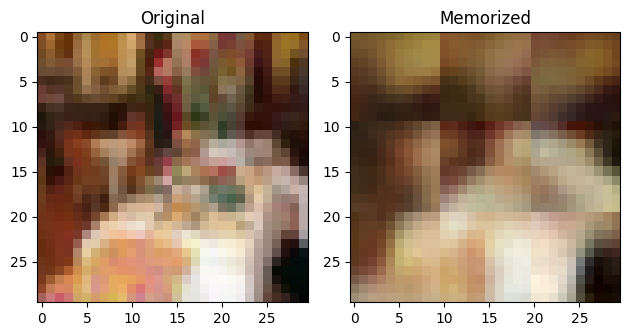

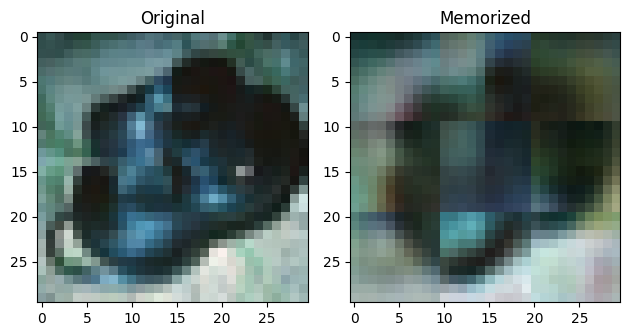

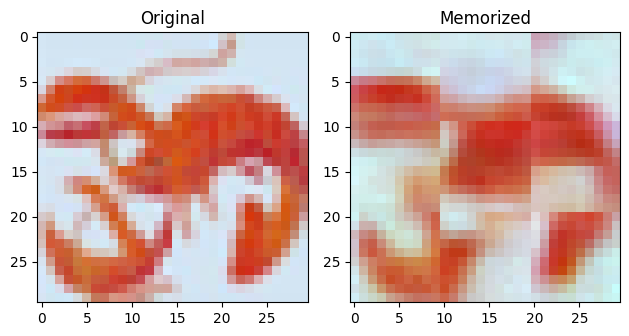

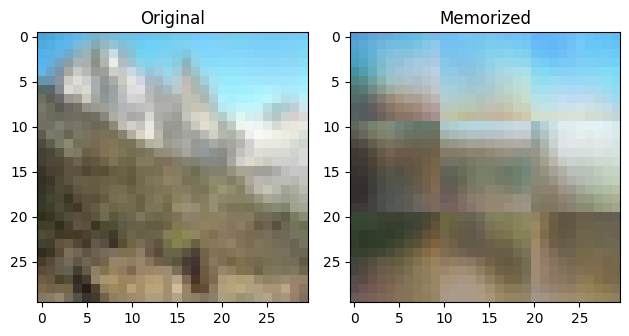

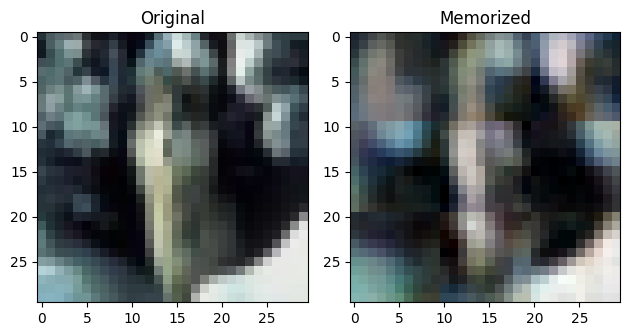

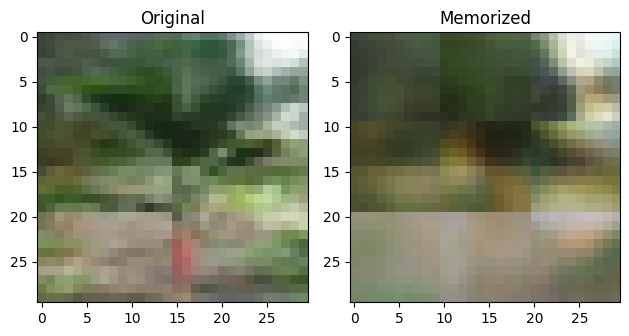

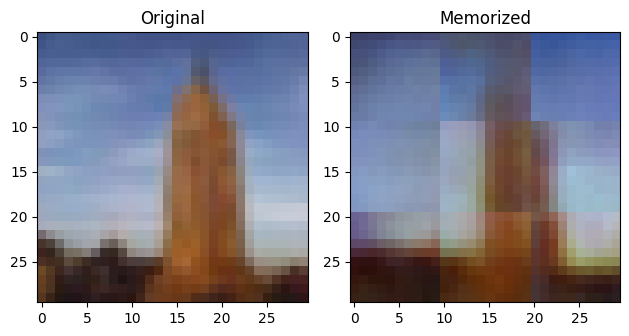

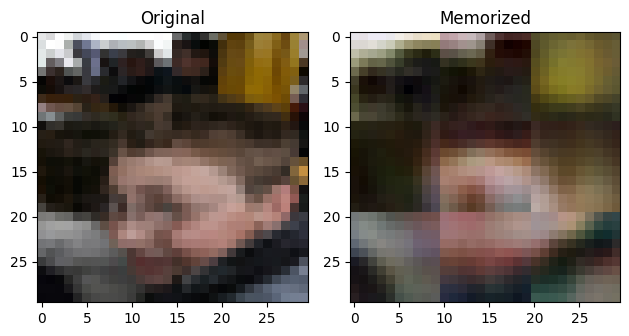

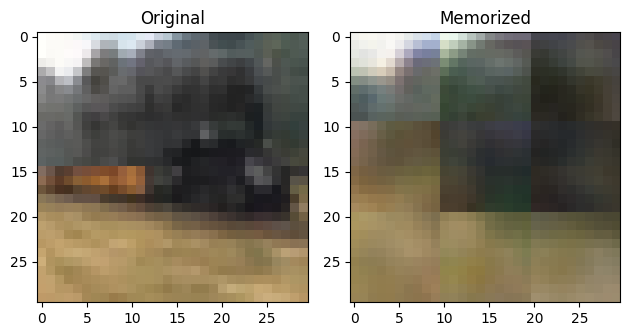

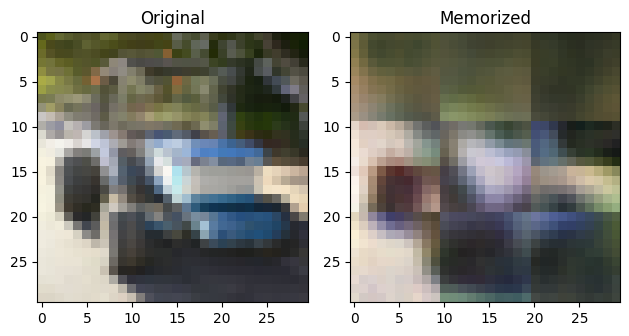

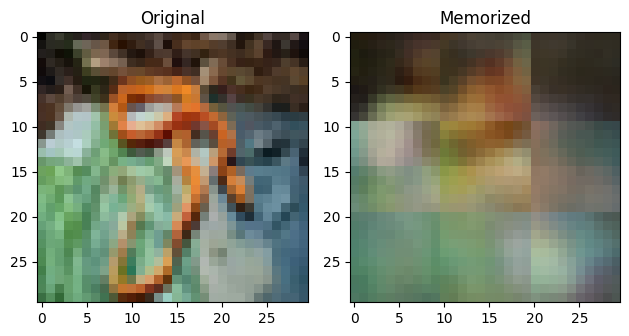

In [45]:
model = best_model
for idx in range(50):
    output, target_image = get_image(idx, model)
    target_image = target_image / 255.0
    target_image_perm = target_image.permute(1, 2, 0).cpu().numpy()
    output_perm = torch.clamp(output, 0, 1).permute(1, 2, 0).cpu().numpy()
    
    fig, ax = plt.subplots(ncols=2, tight_layout=True)
    ax[0].imshow(target_image_perm)
    ax[0].set_title('Original')
    ax[1].imshow(output_perm)
    ax[1].set_title('Memorized')
    plt.show()

In [46]:
def generate_reconstructed_images_and_labels(model, device, mem_dataset):
    num_samples = int(SAMPLE_PERCENTAGE * TRAIN_DATASET_LEN)
    
    reconstructed_images = []
    original_images = []
    labels = []

    for idx in range(num_samples):
        output, target_image = get_image(idx, model)
        reconstructed_images.append(output.to(device))  
        original_images.append(target_image.to(device))  
        
        one_hot_label_region = mem_dataset.gray_codes[idx][1][:-3, :] 
        label = one_hot_label_region.argmax().item()
        labels.append(label)

    reconstructed_images = torch.stack(reconstructed_images)
    original_images = torch.stack(original_images)

    # Normalize the original images to [0, 1]
    original_images = original_images.float() / 255.0
    # Clamp the reconstructed images to [0, 1] to remove any negative values
    reconstructed_images = torch.clamp(reconstructed_images, 0, 1)
    labels = torch.tensor(labels, device=device)
    
    return reconstructed_images, original_images, labels

SSIM

In [47]:
# ssim token from GitHub - https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
import torch
import torch.nn.functional as F

WINDOW_SIZE = 3

def gaussian(window_size, sigma):
    gauss = torch.tensor([-(x - window_size // 2) ** 2 / float(2 * sigma ** 2) for x in range(window_size)])
    gauss = torch.exp(gauss)
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=WINDOW_SIZE, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    window = window.to(img1.device)
    return _ssim(img1, img2, window, window_size, channel, size_average)

# add this function

def calculate_ssim_for_batches(reconstructed_images, original_images, window_size=WINDOW_SIZE):
    if reconstructed_images.dim() == 3:  # Add channel dimension if not present
        reconstructed_images = reconstructed_images.unsqueeze(1)
    if original_images.dim() == 3:  # Add channel dimension if not present
        original_images = original_images.unsqueeze(1)
    
    device = original_images.device
    channel = original_images.size(1)
    window = create_window(window_size, channel).to(device)
    window = window.to(device)
    
    # Calculate SSIM for each image in the batch
    ssim_scores = _ssim(reconstructed_images, original_images, window, window_size, channel, size_average=False)
    return ssim_scores, ssim_scores.mean().item()


In [48]:
# Generate reconstructed images and original images
reconstructed_images, original_images, labels = generate_reconstructed_images_and_labels(best_model, device, mem_dataset)
    
# Calculate SSIM values for the batches
ssim_values, average_ssim = calculate_ssim_for_batches(reconstructed_images, original_images)

# Print SSIM values and the average SSIM
print(f'SSIM values: {ssim_values}')
print(ssim_values.shape)
print(f'Average SSIM: {average_ssim}')

SSIM values: tensor([0.5424, 0.7452, 0.7746,  ..., 0.6162, 0.5623, 0.5250], device='cuda:0')
torch.Size([20000])
Average SSIM: 0.605696976184845
